In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

from scipy.stats import ttest_ind
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score



**Data Exploration | Data Cleaning | Data Wrangling**

Extracting EDF parameters from /home/jupyter-huang36l/ds002721-1.0.3/sub-01/eeg/sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FP2, F7, F3, Fz, F4, F8, T3, C3, Cz, C4, T4, T5, P3, Pz, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


/tmp/ipykernel_2781416/1179084380.py:2: RuntimeWarning: Invalid measurement date encountered in the header.
  visualization=mne.io.read_raw_edf("ds002721-1.0.3/sub-01/eeg/sub-01_task-run2_eeg.edf")


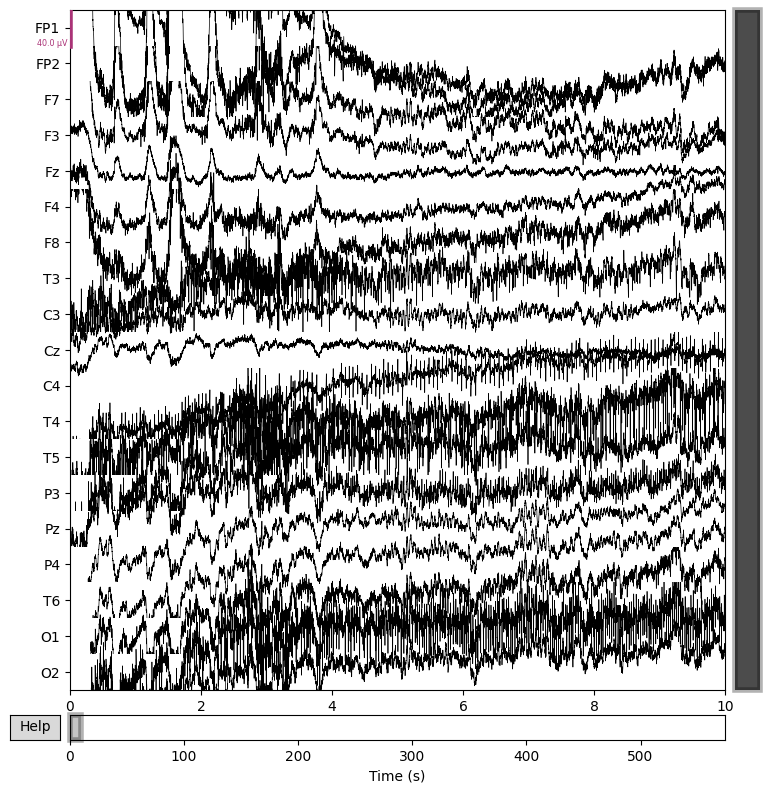

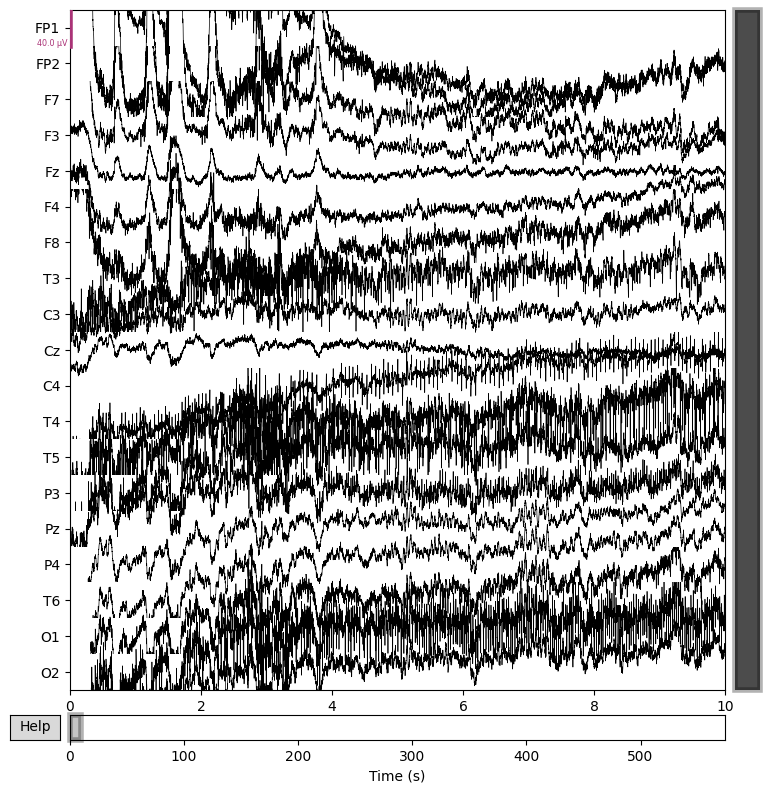

In [4]:
#Data Exploration 
visualization=mne.io.read_raw_edf("ds002721-1.0.3/sub-01/eeg/sub-01_task-run2_eeg.edf")
print(visualization.info)
mne.viz.plot_raw(visualization)

In [5]:
#exploring the event dataframe (example)

events_df = pd.read_csv("ds002721/sub-01/eeg/sub-01_task-run2_events.tsv", sep="\t")
events_df

onset  duration  trial_type
0      2.449        20         263
1      2.689        20         786
2      2.817        20         257
3      3.713        20         257
4      5.689        20         788
..       ...       ...         ...
710  563.203        20         807
711  563.303        20       32768
712  572.623        20         805
713  572.623        20         841
714  572.823        20       32768

[715 rows x 3 columns]

In [6]:
#exploring the music onset (example)
music_onset = events_df[events_df["trial_type"] == 788]
music_onset 

onset  duration  trial_type
4      5.689        20         788
79    65.482        20         788
150  119.310        20         788
224  172.721        20         788
295  224.824        20         788
367  280.979        20         788
439  332.337        20         788
507  387.911        20         788
581  442.642        20         788
652  505.668        20         788

In [8]:
#exploring one music (example)
music_1=visualization.crop(tmin=5.689, tmax=5.689+12)
music_1

<RawEDF | sub-01_task-run2_eeg.edf, 19 x 12001 (12.0 s), ~19 KiB, data not loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_2781416/4068193700.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  music_1.plot_psd(fmax=60)


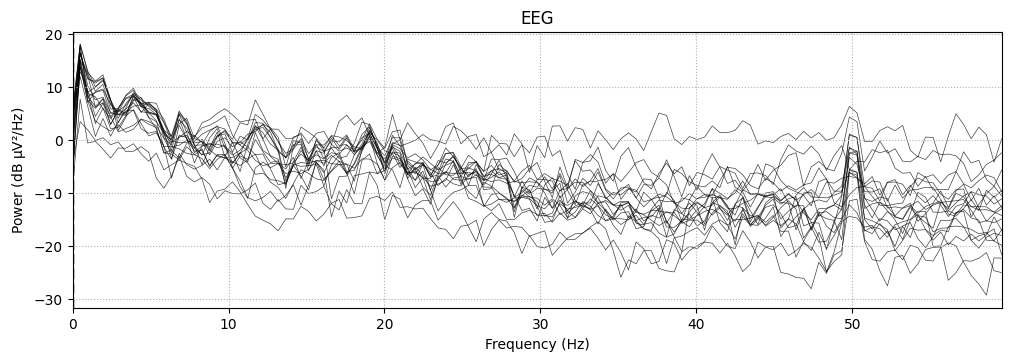

In [9]:
#visualizing one music EEG (example)
music_1.plot_psd(fmax=60) 

    Using multitaper spectrum estimation with 7 DPSS windows


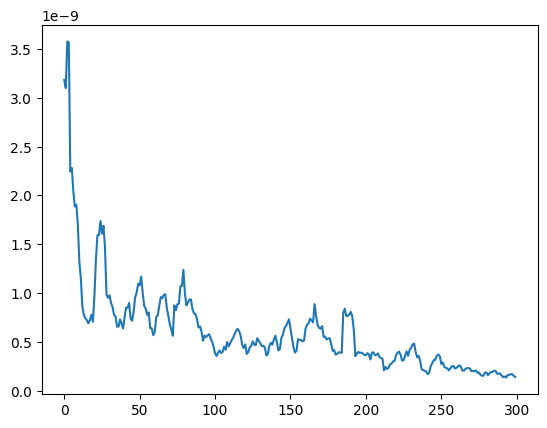

<Power Spectrum (from Raw, multitaper method) | 19 channels × 300 freqs, 5.1-30.0 Hz>

In [12]:
#Averaging 19 Channels (example: range from HZ=5, to HZ =30)

specmusic1=music_1.compute_psd(method="multitaper", tmin=0, tmax=12, fmin=5, fmax=30, picks="eeg")
data = specmusic1.get_data()
mean=np.mean(data,axis=0)
plt.plot(mean)
plt.show()

specmusic1

Skipping participant sub-09 due to missing files.
Combined 'Happy' trials across all participants:
     participant  run  song_index  song_time  question_index  question_time  \
0         sub-01    2           4      5.689               8         22.290   
1         sub-01    2          79     65.482             124        106.086   
2         sub-01    2         150    119.310             173        151.002   
3         sub-01    2         224    172.721             277        212.187   
4         sub-01    2         295    224.824             332        266.202   
...          ...  ...         ...        ...             ...            ...   
1102      sub-30    5         287    247.304             333        285.802   
1103      sub-30    5         364    303.030             401        340.073   
1104      sub-30    5         434    356.567             486        405.021   
1105      sub-30    5         503    417.895             548        466.002   
1106      sub-30    5         57

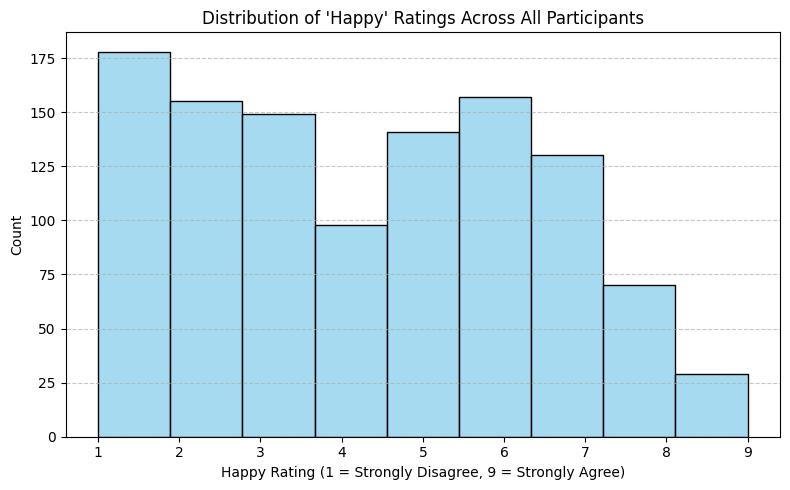

In [13]:
# -------------------------------
# Trial type codes: extracting scores based on happy questions to form our happy rating
# -------------------------------
SONG_CODE = 788
HAPPY_CODE = 805
ANSWER_CODES = list(range(901, 910))  # 901–909

# -------------------------------
# Base path and runs
# -------------------------------
base_path_template = "/srv/data/STAT-344ND/ds002721/sub-{sub_id:02d}/eeg/"
run_files = [
    "sub-{sub_id:02d}_task-run2_events.tsv",
    "sub-{sub_id:02d}_task-run3_events.tsv",
    "sub-{sub_id:02d}_task-run4_events.tsv",
    "sub-{sub_id:02d}_task-run5_events.tsv"
]

# -------------------------------
# Process all participants
# -------------------------------
all_happy_trials = []

for sub_id in range(1, 31):  # sub-01 to sub-31 inclusive
    if sub_id == 9:  # Skip participant with missing data
        print(f"Skipping participant sub-{sub_id:02d} due to missing files.")
        continue

    base_path = base_path_template.format(sub_id=sub_id)

    for run_num, file_template in enumerate(run_files, start=2):  # run2 to run5
        file_name = file_template.format(sub_id=sub_id)
        tsv_path = base_path + file_name

        try:
            events = pd.read_csv(tsv_path, sep='\t')
        except FileNotFoundError:
            print(f"Missing file: {tsv_path}")
            continue

        tt_vec = np.array(events["trial_type"].values)
        song_indices = np.where(tt_vec == SONG_CODE)[0]

        for song_idx in song_indices:
            song_time = events.loc[song_idx, "onset"]

            # Search for Happy question
            happy_idx = None
            for i in range(song_idx + 1, len(tt_vec)):
                if tt_vec[i] == SONG_CODE:
                    break
                if tt_vec[i] == HAPPY_CODE:
                    happy_idx = i
                    break

            if happy_idx is None:
                continue

            # Search for answer
            answer_idx = None
            for j in range(happy_idx + 1, len(tt_vec)):
                if tt_vec[j] == SONG_CODE:
                    break
                if tt_vec[j] in ANSWER_CODES:
                    answer_idx = j
                    break

            if answer_idx is not None:
                answer_code = tt_vec[answer_idx]
                rating = answer_code - 900
                all_happy_trials.append({
                    "participant": f"sub-{sub_id:02d}",
                    "run": run_num,
                    "song_index": song_idx,
                    "song_time": song_time,
                    "question_index": happy_idx,
                    "question_time": events.loc[happy_idx, "onset"],
                    "answer_index": answer_idx,
                    "answer_time": events.loc[answer_idx, "onset"],
                    "answer_code": answer_code,
                    "rating": rating,
                    "score": rating
                })

# -------------------------------
# Combine and display results
# -------------------------------
happy_df = pd.DataFrame(all_happy_trials)

print("Combined 'Happy' trials across all participants:")
print(happy_df)
print(f"\nTotal complete Happy trials: {len(happy_df)}")

# -------------------------------
# Plot histogram of Happy ratings
# -------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(happy_df["rating"], bins=9, kde=False, color="skyblue", edgecolor="black")
plt.title("Distribution of 'Happy' Ratings Across All Participants")
plt.xlabel("Happy Rating (1 = Strongly Disagree, 9 = Strongly Agree)")
plt.ylabel("Count")
plt.xticks(range(1, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



Skipping participant sub-09 due to missing files.
Combined 'Angry' trials across all participants:
     participant  run  song_index  song_time  question_index  question_time  \
0         sub-01    2           4      5.689              45         45.202   
1         sub-01    2          79     65.482             133        109.402   
2         sub-01    2         150    119.310             206        164.202   
3         sub-01    2         224    172.721             254        202.802   
4         sub-01    2         295    224.824             341        268.717   
...          ...  ...         ...        ...             ...            ...   
1165      sub-31    5         351    284.506             355        301.007   
1166      sub-31    5         420    330.058             443        358.602   
1167      sub-31    5         494    381.289             538        423.402   
1168      sub-31    5         572    443.430             595        469.618   
1169      sub-31    5         64

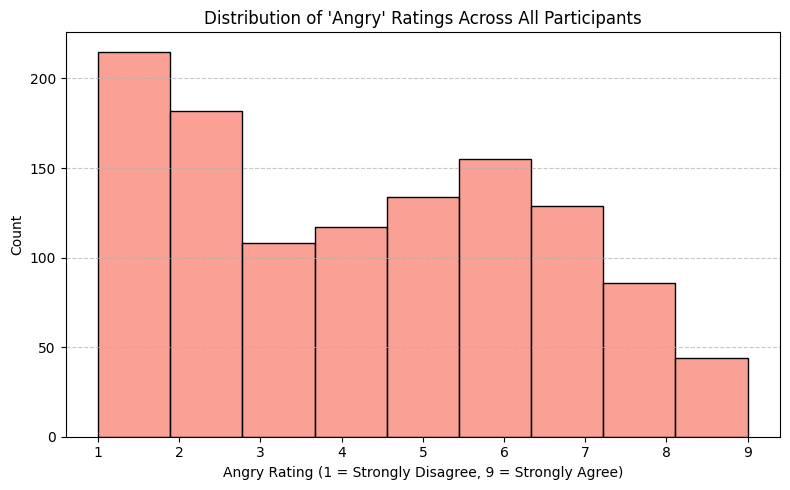

In [75]:
# -------------------------------
# Trial type codes: extracting scores based on angry questions to form our angry rating
# -------------------------------
SONG_CODE = 788
ANGRY_CODE = 803  # new
ANSWER_CODES = list(range(901, 910))  # 901–909

# -------------------------------
# Process all participants — Angry trials
# -------------------------------
all_angry_trials = []

for sub_id in range(1, 32):  # sub-01 to sub-31 inclusive
    if sub_id == 9:  # Skip participant with missing data
        print(f"Skipping participant sub-{sub_id:02d} due to missing files.")
        continue

    base_path = base_path_template.format(sub_id=sub_id)

    for run_num, file_template in enumerate(run_files, start=2):  # run2 to run5
        file_name = file_template.format(sub_id=sub_id)
        tsv_path = base_path + file_name

        try:
            events = pd.read_csv(tsv_path, sep='\t')
        except FileNotFoundError:
            print(f"Missing file: {tsv_path}")
            continue

        tt_vec = np.array(events["trial_type"].values)
        song_indices = np.where(tt_vec == SONG_CODE)[0]

        for song_idx in song_indices:
            song_time = events.loc[song_idx, "onset"]

            # Search for Angry question
            angry_idx = None
            for i in range(song_idx + 1, len(tt_vec)):
                if tt_vec[i] == SONG_CODE:
                    break
                if tt_vec[i] == ANGRY_CODE:
                    angry_idx = i
                    break

            if angry_idx is None:
                continue

            # Search for answer
            answer_idx = None
            for j in range(angry_idx + 1, len(tt_vec)):
                if tt_vec[j] == SONG_CODE:
                    break
                if tt_vec[j] in ANSWER_CODES:
                    answer_idx = j
                    break

            if answer_idx is not None:
                answer_code = tt_vec[answer_idx]
                rating = answer_code - 900
                all_angry_trials.append({
                    "participant": f"sub-{sub_id:02d}",
                    "run": run_num,
                    "song_index": song_idx,
                    "song_time": song_time,
                    "question_index": angry_idx,
                    "question_time": events.loc[angry_idx, "onset"],
                    "answer_index": answer_idx,
                    "answer_time": events.loc[answer_idx, "onset"],
                    "answer_code": answer_code,
                    "rating": rating,
                    "score": rating
                })

# -------------------------------
# Combine and display results — Angry
# -------------------------------
angry_df = pd.DataFrame(all_angry_trials)

print("Combined 'Angry' trials across all participants:")
print(angry_df)
print(f"\nTotal complete Angry trials: {len(angry_df)}")

# -------------------------------
# Plot histogram of Angry ratings
# -------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(angry_df["rating"], bins=9, kde=False, color="salmon", edgecolor="black")
plt.title("Distribution of 'Angry' Ratings Across All Participants")
plt.xlabel("Angry Rating (1 = Strongly Disagree, 9 = Strongly Agree)")
plt.ylabel("Count")
plt.xticks(range(1, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


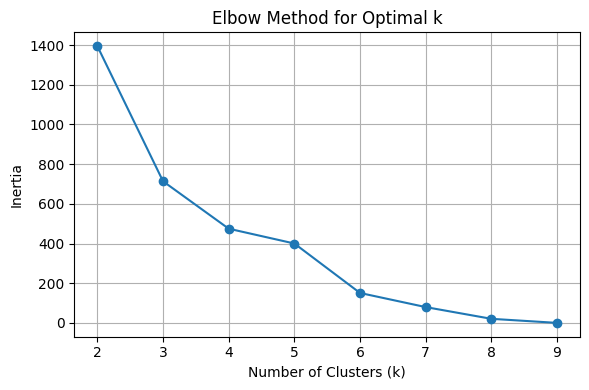

Cluster Statistics:
   rating_cluster  cluster_size  mean_rating
0               0           388     3.979381
1               1           386     6.924870
2               2           333     1.465465

Inertia: 713.51
Silhouette Score: 0.633


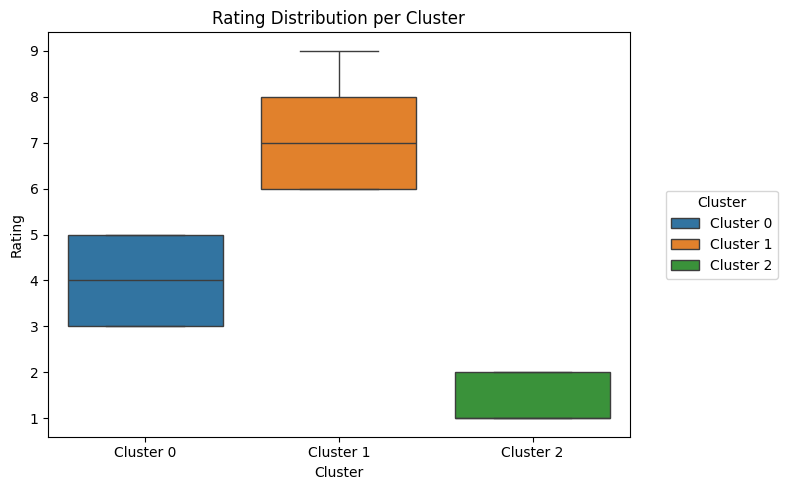

In [15]:
# -------------------------------
# K-means clustering with Elbow Method
# -------------------------------


# Step 1: Prepare data
X = happy_df[["rating"]].values

# Step 2: Elbow Method to find optimal k
inertias = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Apply KMeans with chosen k (e.g., 3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)
happy_df["rating_cluster"] = labels

# Step 4: Cluster statistics
cluster_stats = happy_df.groupby("rating_cluster").agg(
    cluster_size=("rating", "size"),
    mean_rating=("rating", "mean")
).reset_index()

# Step 5: Evaluation metrics
inertia = kmeans.inertia_
sil_score = silhouette_score(X, labels)

print("Cluster Statistics:")
print(cluster_stats)
print(f"\nInertia: {inertia:.2f}")
print(f"Silhouette Score: {sil_score:.3f}")

# -------------------------------
# Visualization
# -------------------------------

# Set consistent color palette
cluster_palette = {0: "tab:blue", 1: "tab:orange", 2: "tab:green"}

# Create figure and axis
plt.figure(figsize=(8, 5))
ax = sns.boxplot(
    x="rating_cluster",
    y="rating",
    data=happy_df,
    hue="rating_cluster",
    palette=cluster_palette,
    dodge=False
)

# Title and labels
plt.title("Rating Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Rating")
plt.xticks(ticks=range(k), labels=[f"Cluster {i}" for i in range(k)])

# Legend outside the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[f"Cluster {label}" for label in sorted(happy_df['rating_cluster'].unique())],
          title="Cluster", loc="center left", bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()  # Adjust layout to fit everything
plt.show()



#clusters - 
#    0: "Medium",  # Cluster 0 has mean rating ≈ 4
#    1: "High",    # Cluster 1 has mean rating ≈ 7
#   2: "Low"      # Cluster 2 has mean rating ≈ 1.5


In [16]:
# -------------------------------
# T-test: t-test between the three clusters to check if the clusters are significantly different from each other.
# -------------------------------
# Extract ratings by cluster
ratings_by_cluster = {
    cluster: happy_df[happy_df["rating_cluster"] == cluster]["rating"].values
    for cluster in sorted(happy_df["rating_cluster"].unique())
}

# Define cluster pairs to test
cluster_pairs = [(0, 1), (0, 2), (1, 2)]

# Perform t-tests and track significance
print("T-Tests Between Clusters:\n" + "-" * 35)
significant_results = []

for c1, c2 in cluster_pairs:
    r1 = ratings_by_cluster[c1]
    r2 = ratings_by_cluster[c2]
    t_stat, p_val = ttest_ind(r1, r2, equal_var=False)
    sig_flag = "✅ Significant" if p_val < 0.05 else "❌ Not significant"
    print(f"Cluster {c1} vs Cluster {c2}: t = {t_stat:.3f}, p = {p_val:.2e} → {sig_flag}")
    
    if p_val < 0.05:
        significant_results.append((c1, c2, p_val))

# Summary of significant differences
print("\nSignificant Differences (p < 0.05):")
if significant_results:
    for c1, c2, p_val in significant_results:
        print(f" - Cluster {c1} vs Cluster {c2} (p = {p_val:.2e})")
else:
    print("None found.")


# We performed t-tests to compare the average ratings between each pair of clusters. 
# The results show that all three comparisons are statistically significant, meaning the differences in ratings between the clusters are not due to chance. 
# Specifically, Cluster 0 is significantly different from both Cluster 1 and Cluster 2, and Cluster 1 is also significantly different from Cluster 2. 
# The p-values for all comparisons were extremely small (much smaller than 0.05), which confirms that the rating levels in each cluster are clearly and meaningfully different. 
# This supports the idea that the clustering worked well in separating the data into distinct groups based on rating.


T-Tests Between Clusters:
-----------------------------------
Cluster 0 vs Cluster 1: t = -45.323, p = 5.44e-219 → ✅ Significant
Cluster 0 vs Cluster 2: t = 48.564, p = 7.11e-216 → ✅ Significant
Cluster 1 vs Cluster 2: t = 98.971, p = 0.00e+00 → ✅ Significant

Significant Differences (p < 0.05):
 - Cluster 0 vs Cluster 1 (p = 5.44e-219)
 - Cluster 0 vs Cluster 2 (p = 7.11e-216)
 - Cluster 1 vs Cluster 2 (p = 0.00e+00)


In [17]:
# -------------------------------
# Extracing PSD from all participants
# -------------------------------

def process_one_song(raw, onset_time, duration=12, plot=False):
    music_segment = raw.copy().crop(tmin=onset_time, tmax=onset_time + duration)
    spec = music_segment.compute_psd(method="multitaper", tmin=0, tmax=duration, fmin=5, fmax=30, picks="eeg")
    data = spec.get_data()
    freqs = spec.freqs
    mean_psd = np.mean(data, axis=0)
    return mean_psd, freqs

# ----------
all_subjects_features = []
all_subject_ids = []

# Define path template and filenames
base_path_template = "/srv/data/STAT-344ND/ds002721/sub-{sub_id:02d}/eeg/"
run_files = [
    "sub-{sub_id:02d}_task-run2_events.tsv",
    "sub-{sub_id:02d}_task-run3_events.tsv",
    "sub-{sub_id:02d}_task-run4_events.tsv",
    "sub-{sub_id:02d}_task-run5_events.tsv"
]

# -----sub-01 to sub-32-----
for subj_id in range(1, 32):
    subject = f"sub-{subj_id:02d}"
    print(f"\n===== Processing {subject} =====")

    subject_features = []

    try:
        for run_file in run_files:
            events_file = run_file.format(sub_id=subj_id)
            edf_file = events_file.replace("_events.tsv", "_eeg.edf")
            base_path = base_path_template.format(sub_id=subj_id)

            edf_path = os.path.join(base_path, edf_file)
            events_path = os.path.join(base_path, events_file)

            if not os.path.exists(edf_path) or not os.path.exists(events_path):
                print(f"  Missing files for {subject}, skipping {edf_file}...")
                break  # skip the subject if any run is missing

            print(f"  Run file: {edf_path}")
            raw = mne.io.read_raw_edf(edf_path, preload=True)
            events_df = pd.read_csv(events_path, sep="\t")
            onsets = events_df[events_df["trial_type"] == 788]["onset"].values[:10]

            for i, onset_time in enumerate(onsets):
                print(f"    Song {i+1}: {onset_time:.2f}s")
                mean_psd, freqs = process_one_song(raw, onset_time, duration=12)
                subject_features.append(mean_psd)
                all_subject_ids.append(subject)

        if subject_features:
            all_subjects_features.append(np.vstack(subject_features))
            print(f"  Done with {subject} — {len(subject_features)} songs processed.")
        else:
            print(f"  No valid data for {subject}.")

    except Exception as e:
        print(f"  Error processing {subject}: {e}")
        continue

# Stack features (songs × freqs)
if all_subjects_features:
    final_features = np.vstack(all_subjects_features)
    print("Final features shape:", final_features.shape)
    subject_id_array = np.array(all_subject_ids)
    np.save("psd_features.npy", final_features)
    np.save("subject_ids.npy", subject_id_array)
else:
    print("No features extracted.")



===== Processing sub-01 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 573999  =      0.000 ...   573.999 secs...
    Song 1: 5.69s


/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 119.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 224.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 280.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 332.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 387.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 442.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 505.67s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 108.25s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 160.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 211.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 267.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 318.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 371.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 434.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 504.01s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 54.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 160.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 209.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 257.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 319.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 371.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 422.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 469.64s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 112.59s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 279.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 323.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 380.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 433.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 500.10s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-01 — 40 songs processed.

===== Processing sub-02 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 76.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 142.10s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 203.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 314.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 370.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 420.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 473.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 522.76s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 52.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 104.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 151.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 209.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 260.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 314.39s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 365.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 414.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 465.46s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 55.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 109.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 162.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 267.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 319.59s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 368.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 416.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 466.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 54.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 105.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 154.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 203.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 250.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 299.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 347.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 394.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 447.81s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-02 — 40 songs processed.

===== Processing sub-03 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 94.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 175.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 262.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 319.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 404.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 464.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 518.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 573.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 637.95s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 82.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 157.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 214.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 283.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 346.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 398.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 446.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 498.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 574.26s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 193.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 326.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 386.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 440.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 493.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 555.46s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 183.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 245.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 306.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 365.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 540.61s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-03 — 40 songs processed.

===== Processing sub-04 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 95.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 172.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 233.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 306.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 369.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 450.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 511.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 585.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 661.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 70.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 139.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 199.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 263.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 319.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 377.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 428.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 500.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 558.15s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 121.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 179.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 236.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 294.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 356.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 416.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 469.19s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 535.59s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 120.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 173.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 337.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 394.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 448.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 503.85s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-04 — 40 songs processed.

===== Processing sub-05 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 77.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 155.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 224.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 295.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 364.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 431.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 496.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 567.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 622.63s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 136.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 323.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 379.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 442.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 501.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 557.21s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 121.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 178.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 231.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 293.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 345.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 401.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 521.20s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 118.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.19s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 337.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 396.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 453.19s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 509.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-05 — 40 songs processed.

===== Processing sub-06 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 176.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 240.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 295.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 346.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 398.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 454.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 508.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 170.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 223.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 277.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 331.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 391.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 441.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 501.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 54.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 108.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 164.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 214.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 273.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 330.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 380.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 434.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 484.36s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 106.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 156.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 212.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 262.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 314.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 363.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 411.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 461.25s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-06 — 40 songs processed.

===== Processing sub-07 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 72.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 145.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 213.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 284.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 344.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 393.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 448.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 512.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 562.43s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 63.39s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 113.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 163.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 224.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 287.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 344.45s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 399.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 455.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 509.32s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 174.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 229.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 289.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 344.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 391.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 444.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 498.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 227.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 280.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 340.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 391.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 453.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 511.63s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-07 — 40 songs processed.

===== Processing sub-08 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 81.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 141.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 194.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 257.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 311.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 374.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 489.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 546.77s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 116.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 170.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 224.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 286.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 345.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 412.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 460.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 513.15s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 56.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 153.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 208.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 262.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 311.01s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 358.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 405.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 454.54s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 152.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 203.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 251.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 298.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 345.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 395.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 445.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-08 — 40 songs processed.

===== Processing sub-09 =====
  Missing files for sub-09, skipping sub-09_task-run2_eeg.edf...
  No valid data for sub-09.

===== Processing sub-10 =====
  Run file: /s

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 79.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 144.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 219.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 289.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 352.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 416.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 480.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 531.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 596.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 191.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 250.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 304.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 367.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 431.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 542.79s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 123.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 177.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 242.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 300.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 357.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 414.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 468.25s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 534.06s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 187.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 242.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 295.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 353.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 414.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 467.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 525.10s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-10 — 40 songs processed.

===== Processing sub-11 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 85.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 185.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 288.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 362.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 433.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 518.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 591.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 681.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 757.05s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 78.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 157.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 218.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 293.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 356.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 407.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 476.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 540.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 603.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 125.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 181.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 236.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 292.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 358.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 469.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 529.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 109.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 159.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 218.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 267.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 368.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 416.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 466.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-11 — 40 songs processed.

===== Processing sub-12 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 143.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 203.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 263.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 315.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 381.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 439.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 489.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 548.57s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 107.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 161.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 211.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 266.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 364.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 416.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 476.80s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 112.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 165.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 266.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 319.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 370.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 430.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 481.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 55.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 105.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 158.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 205.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 254.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 308.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 356.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 410.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 462.15s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-12 — 40 songs processed.

===== Processing sub-13 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 138.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 205.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 274.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 350.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 431.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 518.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 586.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 655.21s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 131.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 324.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 383.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 448.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 509.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 572.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 130.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 190.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 243.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 297.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 363.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 420.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 482.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 548.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 67.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 127.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 242.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 304.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 360.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 417.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 468.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 522.08s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-13 — 40 songs processed.

===== Processing sub-14 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 87.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 162.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 242.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 303.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 371.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 466.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 535.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 613.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 690.86s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 131.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 192.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 320.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 374.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 435.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 491.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 553.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 86.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 153.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 216.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 303.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 364.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 435.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 505.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 587.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 657.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run5_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 82.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 160.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 224.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 301.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 367.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 429.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 487.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 539.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 599.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-14 — 40 songs processed.

===== Processing sub-15 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 93.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 175.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 238.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 305.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 363.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 424.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 495.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 555.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 618.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 137.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 199.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 309.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 360.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 473.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 533.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 119.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 235.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 292.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 357.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 416.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 470.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 527.73s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 72.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 129.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 190.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 249.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 306.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 357.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 409.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 514.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-15 — 40 songs processed.

===== Processing sub-16 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 86.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 161.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 221.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 283.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 341.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 398.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 462.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 523.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 589.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 112.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 227.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 289.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 345.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 413.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 478.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 535.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 81.45s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 140.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 196.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 259.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 322.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 378.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 443.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 500.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 560.87s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 126.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 174.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 236.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 290.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 351.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 419.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 485.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 554.22s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-16 — 40 songs processed.

===== Processing sub-17 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 127.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 238.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 295.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 352.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 407.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 512.82s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 110.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 162.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 214.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 264.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 364.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 413.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 468.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 55.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 105.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 155.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 203.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 255.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 303.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 351.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 405.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 456.49s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 108.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 156.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 206.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 257.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 308.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 358.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 408.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 459.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-17 — 40 songs processed.

===== Processing sub-18 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 156.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 235.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 315.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 411.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 494.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 571.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 655.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 732.27s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 103.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 177.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 244.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 314.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 400.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 473.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 541.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 598.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 665.38s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run4_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 132.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 197.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 256.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 311.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 390.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 461.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 532.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 605.11s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 144.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 308.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 376.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 444.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 516.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 584.30s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-18 — 40 songs processed.

===== Processing sub-19 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 103.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 196.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 270.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 336.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 415.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 486.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 579.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 652.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 725.86s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run3_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 73.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 132.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 206.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 269.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 338.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 405.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 465.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 526.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 598.24s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 127.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 194.39s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 252.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 315.01s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 376.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 433.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 496.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 565.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 181.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 235.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 286.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 352.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 411.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 471.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 526.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-19 — 40 songs processed.

===== Processing sub-20 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 123.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 180.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 234.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 288.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 346.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 399.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 461.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 509.45s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 125.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 247.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 304.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 362.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 421.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 484.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 535.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 60.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 114.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 192.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 246.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 301.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 354.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 412.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 470.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 518.13s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 60.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 114.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 164.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 287.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 339.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 398.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 478.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 526.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-20 — 40 songs processed.

===== Processing sub-21 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 105.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 196.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 292.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 377.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 463.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 559.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 628.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 696.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 758.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run3_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 163.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 233.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 301.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 369.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 439.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 509.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 580.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 643.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run4_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 121.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 190.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 251.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 311.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 367.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 437.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 499.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 559.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 616.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run5_eeg.edf...
EDF file detected
Setting chann

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 68.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 189.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 252.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 317.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 391.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 452.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 512.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 574.82s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-21 — 40 songs processed.

===== Processing sub-22 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 88.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 176.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 249.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 328.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 409.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 499.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 568.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 659.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 725.56s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 74.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 139.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 213.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 281.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 350.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 426.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 503.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 580.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 652.64s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run4_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 143.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 218.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 303.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 385.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 464.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 536.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 622.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 695.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run5_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)



    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 79.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 154.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 235.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 310.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 372.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 435.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 495.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 561.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 627.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-22 — 40 songs processed.

===== Processing sub-23 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds00272

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 73.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 143.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 211.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 289.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 366.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 451.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 543.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 619.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 701.33s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 84.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 170.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 251.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 331.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 406.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 499.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 601.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 660.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 718.12s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run4_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 160.10s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 216.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 276.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 353.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 439.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 493.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 552.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 606.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 115.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 166.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 272.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 332.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 397.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 454.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 511.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-23 — 40 songs processed.

===== Processing sub-24 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 68.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 135.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 197.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 316.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 376.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 438.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 486.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 540.57s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 115.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 175.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 227.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 332.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 401.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 448.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 495.26s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 59.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 110.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 163.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 215.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 265.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 376.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 426.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 497.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 150.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 208.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 258.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 307.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 354.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 410.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 465.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-24 — 40 songs processed.

===== Processing sub-25 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 136.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 208.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 270.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 336.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 404.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 466.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 527.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 587.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 70.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 328.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 387.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 442.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 502.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 561.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 124.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 183.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 246.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 302.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 364.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 549.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 115.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 168.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 233.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 291.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 359.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 475.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 528.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-25 — 40 songs processed.

===== Processing sub-26 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 161.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 233.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 305.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 380.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 459.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 540.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 611.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 676.25s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 126.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 250.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 317.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 381.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 445.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 507.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 567.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 124.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 252.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 326.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 383.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 441.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 497.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 555.71s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 116.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 179.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 234.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 290.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 347.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 401.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 454.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 511.41s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-26 — 40 songs processed.

===== Processing sub-27 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 80.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 149.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 310.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 378.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 444.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 509.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 580.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 640.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 699.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 140.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 194.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 257.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 318.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 381.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 448.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 505.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 591.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 130.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 188.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 241.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 308.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 363.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 419.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 486.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 551.38s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 113.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 165.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 220.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 279.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 333.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 384.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 431.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 487.72s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-27 — 40 songs processed.

===== Processing sub-28 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 68.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 193.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 259.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 320.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 377.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 430.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 483.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 540.88s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 176.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 231.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 336.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 387.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 441.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 500.11s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 120.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 174.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 223.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 279.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 338.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 390.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 444.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 496.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 109.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 164.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 272.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 328.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 374.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 422.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 475.11s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-28 — 40 songs processed.

===== Processing sub-29 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 79.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 155.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 210.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 264.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 319.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 385.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 452.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 505.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 563.86s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 104.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 165.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 234.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 293.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 355.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 414.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 466.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 520.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 594.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run4_eeg.edf...
EDF file detected
Setting chann

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 80.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 152.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 229.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 286.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 348.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 400.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 467.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 543.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 599.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 67.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 190.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 248.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 312.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 371.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 545.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-29 — 40 songs processed.

===== Processing sub-30 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 152.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 216.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 287.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 361.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 433.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 500.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 566.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 633.50s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 74.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 139.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 207.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 273.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 352.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 416.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 474.10s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 540.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 605.34s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 72.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 130.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 189.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 245.45s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 301.25s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 362.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 488.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 549.18s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 70.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 247.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 303.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 356.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 417.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 480.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 539.62s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-30 — 40 songs processed.

===== Processing sub-31 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 133.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 205.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 268.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 342.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 393.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 447.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 500.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 560.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 608.26s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run3_eeg.edf...
EDF file detected
Setting chann

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 181.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 241.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 288.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 343.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 407.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 510.85s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 56.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 178.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 225.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 271.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 325.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 382.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 431.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 483.19s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/1821798877.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 134.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 184.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 231.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 284.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 330.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 381.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 443.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 497.51s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-31 — 40 songs processed.
Final features shape: (1200, 300)


In [19]:
# ---------------------------
# creating 3 bandpower features (theta, alpha, beta) based on previous PSDs.
# ---------------------------
bands = {
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (13, 30)
}

band_features = []

for psd in final_features:
    band_vector = []
    for band, (low, high) in bands.items():
        idx = (freqs >= low) & (freqs < high)
        if np.any(idx):
            power = np.mean(psd[idx])
        else:
            power = np.nan
        band_vector.append(power)
    band_features.append(band_vector)

band_features = np.array(band_features)
print("Band feature shape:", band_features.shape)  # should be (n_trials, 3)

# Optional: Save for reuse
np.save("band_features.npy", band_features)



Band feature shape: (1200, 3)


**Statistical Inference**

X shape: (1107, 3), y shape: (1107,)
Training Accuracy: 35.03%
Cross-Validated Accuracy: 35.05% ± 0.18%

Classification Report:
              precision    recall  f1-score   support

           0       0.35      1.00      0.52        78
           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00        67

    accuracy                           0.35       222
   macro avg       0.12      0.33      0.17       222
weighted avg       0.12      0.35      0.18       222



/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

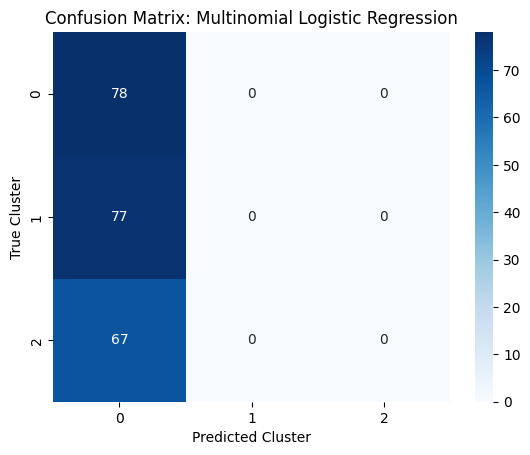

Model coefficients shape: (3, 3)

Model Coefficients:
                  theta         alpha          beta
Class                                              
Cluster 0  5.422882e-10  1.747465e-09  3.580876e-11
Cluster 1  4.847638e-10 -4.009681e-10  2.209636e-11
Cluster 2 -1.027052e-09 -1.346497e-09 -5.790512e-11


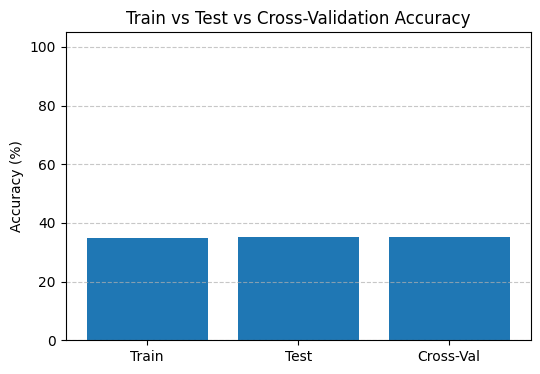


LOSO-CV Accuracy: 28.03% ± 8.44%


/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

In [20]:

# ---------------------------
# Define model input/output: Creating a multinomial regression with 3 d
# ---------------------------
X = band_features
y = happy_df["rating_cluster"].values

# Align shapes
min_len = min(len(X), len(y))
X = X[:min_len]
y = y[:min_len]


# Ensure equal lengths (in case of mismatch)
min_len = min(len(X), len(y))
X = X[:min_len]
y = y[:min_len]

print(f"X shape: {X.shape}, y shape: {y.shape}")

# ---------------------------
# 2. Train/Test Split
# ---------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 3. Train Multinomial Logistic Regression
# ---------------------------
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    multi_class="multinomial", solver="lbfgs", max_iter=500
)
model.fit(X_train, y_train)

# ---------------------------
# 3.5 Evaluate on Training Set
# ---------------------------
train_accuracy = model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# ---------------------------
# 3.6 Cross-Validation Score
# ---------------------------

cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}% ± {cv_scores.std() * 100:.2f}%")

# ---------------------------
# 4. Evaluate the Model
# ---------------------------


y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ---------------------------
# 5. Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.title("Confusion Matrix: Multinomial Logistic Regression")
plt.show()

# ---------------------------
# 6. Coefficients
# ---------------------------

# Step 1: Inspect shape of model coefficients
print("Model coefficients shape:", model.coef_.shape)

# Step 2: Dynamically assign correct column names
if model.coef_.shape[1] == 3:
    feature_names = ["theta", "alpha", "beta"]
elif model.coef_.shape[1] == 1:
    feature_names = ["rating"]
else:
    feature_names = [f"feature_{i}" for i in range(model.coef_.shape[1])]

# Step 3: Create coefficient DataFrame
coef_df = pd.DataFrame(model.coef_, columns=feature_names)
coef_df["Class"] = [f"Cluster {i}" for i in range(model.coef_.shape[0])]

# Step 4: Display
print("\nModel Coefficients:")
print(coef_df.set_index("Class"))

import matplotlib.pyplot as plt

accuracies = [
    model.score(X_train, y_train) * 100,         # Train
    model.score(X_test, y_test) * 100,           # Test
    cv_scores.mean() * 100                       # Cross-validated
]
labels = ["Train", "Test", "Cross-Val"]

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies)
plt.ylim(0, 105)
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test vs Cross-Validation Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Load subject IDs (if not already in memory)
# subject_ids = np.load("subject_ids.npy")  # shape = [n_trials]


import numpy as np

# Load the array of subject identifiers
subject_ids = np.load("subject_ids.npy")
min_len = min(len(X), len(y), len(subject_ids))
X = X[:min_len]
y = y[:min_len]
subject_ids = subject_ids[:min_len]



# Set up LOSO-CV
logo = LeaveOneGroupOut()

accuracies = []
all_preds = []
all_true = []

model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)

for train_idx, test_idx in logo.split(X, y, groups=subject_ids):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    all_preds.extend(y_pred)
    all_true.extend(y_test)

# Report LOSO results
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
print(f"\nLOSO-CV Accuracy: {mean_acc * 100:.2f}% ± {std_acc * 100:.2f}%")




In [21]:
#Random forest
# Set up model
model = RandomForestClassifier(random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores
accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
precision_scores = cross_val_score(model, X, y, cv=cv, scoring='precision_macro')
recall_scores = cross_val_score(model, X, y, cv=cv, scoring='recall_macro')
f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

# Print average scores
print("Cross-Validation Results (5-fold):")
print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Precision (macro): {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall (macro): {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"F1-score (macro): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



Cross-Validation Results (5-fold):
Accuracy: 0.3207 ± 0.0159
Precision (macro): 0.3211 ± 0.0166
Recall (macro): 0.3190 ± 0.0169
F1-score (macro): 0.3183 ± 0.0167


Class distribution:
    Class  Count
0      0    388
1      1    386
2      2    333


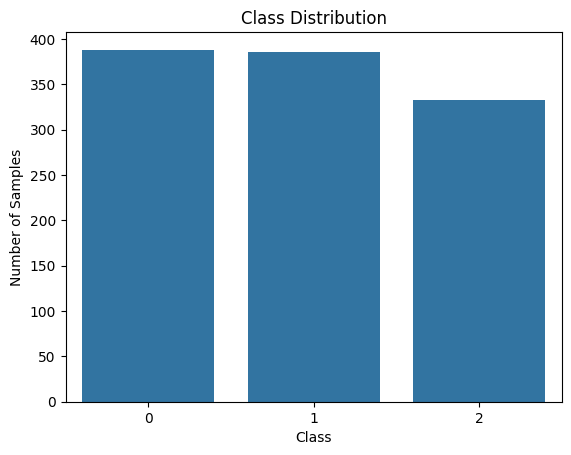

The classes are well-balanced overall. There's a small difference: Class 2 has slightly fewer samples (333 vs. ~388), but not enough to cause serious imbalance.


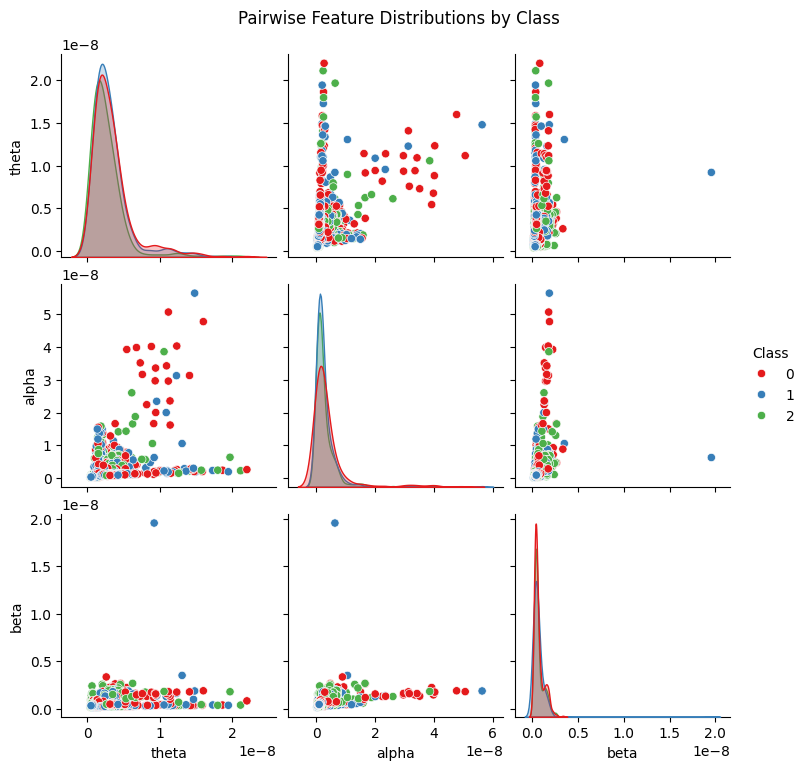

Your features do not clearly separate the classes — this makes it hard for any model, even a Random Forest, to perform well. This is likely the main reason for model’s poor cross-validated accuracy (~32%).


In [22]:
# 1. Check Class Balance

# If y is a NumPy array:
unique, counts = np.unique(y, return_counts=True)
class_distribution = pd.DataFrame({'Class': unique, 'Count': counts})

print("Class distribution:\n", class_distribution)

# Optional: plot
sns.barplot(x='Class', y='Count', data=class_distribution)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

print("The classes are well-balanced overall. There's a small difference: Class 2 has slightly fewer samples (333 vs. ~388), but not enough to cause serious imbalance.")

#Visualize Feature Separability by Class
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# If you have X as a DataFrame and y as labels:
df = pd.DataFrame(X, columns=['theta', 'alpha', 'beta'])
df['Class'] = y

# Pairplot: visualizes feature relationships by class
sns.pairplot(df, hue='Class', palette='Set1')
plt.suptitle('Pairwise Feature Distributions by Class', y=1.02)
plt.show()

print("Your features do not clearly separate the classes — this makes it hard for any model, even a Random Forest, to perform well. This is likely the main reason for model’s poor cross-validated accuracy (~32%).")


**T-test between happy song vs unhappy song based on 5 bands(note: every analysis below is based on 5 bands)**

In [23]:
# -------------------------------
# Extracing PSD from all participants: The range is from HZ=0 to HZ=60)
# -------------------------------

def process_one_song(raw, onset_time, duration=12, plot=False):
    music_segment = raw.copy().crop(tmin=onset_time, tmax=onset_time + duration)
    spec = music_segment.compute_psd(method="multitaper", tmin=0, tmax=duration, fmin=0, fmax=60, picks="eeg")
    data = spec.get_data()
    freqs = spec.freqs
    mean_psd = np.mean(data, axis=0)
    return mean_psd, freqs

# ----------
all_subjects_features = []
all_subject_ids = []

# Define path template and filenames
base_path_template = "/srv/data/STAT-344ND/ds002721/sub-{sub_id:02d}/eeg/"
run_files = [
    "sub-{sub_id:02d}_task-run2_events.tsv",
    "sub-{sub_id:02d}_task-run3_events.tsv",
    "sub-{sub_id:02d}_task-run4_events.tsv",
    "sub-{sub_id:02d}_task-run5_events.tsv"
]

# -----sub-01 to sub-32-----
for subj_id in range(1, 32):
    subject = f"sub-{subj_id:02d}"
    print(f"\n===== Processing {subject} =====")

    subject_features = []

    try:
        for run_file in run_files:
            events_file = run_file.format(sub_id=subj_id)
            edf_file = events_file.replace("_events.tsv", "_eeg.edf")
            base_path = base_path_template.format(sub_id=subj_id)

            edf_path = os.path.join(base_path, edf_file)
            events_path = os.path.join(base_path, events_file)

            if not os.path.exists(edf_path) or not os.path.exists(events_path):
                print(f"  Missing files for {subject}, skipping {edf_file}...")
                break  # skip the subject if any run is missing

            print(f"  Run file: {edf_path}")
            raw = mne.io.read_raw_edf(edf_path, preload=True)
            events_df = pd.read_csv(events_path, sep="\t")
            onsets = events_df[events_df["trial_type"] == 788]["onset"].values[:10]

            for i, onset_time in enumerate(onsets):
                print(f"    Song {i+1}: {onset_time:.2f}s")
                mean_psd, freqs = process_one_song(raw, onset_time, duration=12)
                subject_features.append(mean_psd)
                all_subject_ids.append(subject)

        if subject_features:
            all_subjects_features.append(np.vstack(subject_features))
            print(f"  Done with {subject} — {len(subject_features)} songs processed.")
        else:
            print(f"  No valid data for {subject}.")

    except Exception as e:
        print(f"  Error processing {subject}: {e}")
        continue

# Stack features (songs × freqs)
if all_subjects_features:
    final_features = np.vstack(all_subjects_features)
    print("Final features shape:", final_features.shape)
    subject_id_array = np.array(all_subject_ids)
    np.save("psd_features.npy", final_features)
    np.save("subject_ids.npy", subject_id_array)
else:
    print("No features extracted.")



===== Processing sub-01 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run2_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 573999  =      0.000 ...   573.999 secs...
    Song 1: 5.69s


/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 119.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 224.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 280.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 332.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 387.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 442.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 505.67s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 108.25s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 160.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 211.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 267.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 318.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 371.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 434.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 504.01s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 54.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 160.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 209.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 257.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 319.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 371.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 422.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 469.64s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-01/eeg/sub-01_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 112.59s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 279.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 323.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 380.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 433.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 500.10s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-01 — 40 songs processed.

===== Processing sub-02 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 76.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 142.10s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 203.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 314.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 370.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 420.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 473.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 522.76s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 52.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 104.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 151.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 209.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 260.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 314.39s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 365.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 414.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 465.46s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 55.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 109.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 162.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 267.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 319.59s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 368.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 416.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 466.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-02/eeg/sub-02_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 54.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 105.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 154.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 203.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 250.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 299.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 347.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 394.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 447.81s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-02 — 40 songs processed.

===== Processing sub-03 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 94.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 175.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 262.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 319.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 404.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 464.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 518.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 573.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 637.95s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 82.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 157.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 214.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 283.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 346.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 398.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 446.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 498.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 574.26s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 193.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 326.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 386.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 440.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 493.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 555.46s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-03/eeg/sub-03_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 183.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 245.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 306.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 365.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 540.61s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-03 — 40 songs processed.

===== Processing sub-04 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 95.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 172.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 233.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 306.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 369.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 450.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 511.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 585.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 661.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 70.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 139.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 199.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 263.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 319.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 377.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 428.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 500.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 558.15s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 121.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 179.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 236.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 294.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 356.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 416.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 469.19s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 535.59s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-04/eeg/sub-04_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 120.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 173.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 337.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 394.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 448.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 503.85s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-04 — 40 songs processed.

===== Processing sub-05 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 77.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 155.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 224.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 295.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 364.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 431.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 496.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 567.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 622.63s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 136.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 323.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 379.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 442.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 501.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 557.21s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 121.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 178.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 231.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 293.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 345.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 401.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 521.20s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-05/eeg/sub-05_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 118.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.19s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 337.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 396.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 453.19s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 509.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-05 — 40 songs processed.

===== Processing sub-06 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 176.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 240.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 295.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 346.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 398.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 454.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 508.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 170.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 223.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 277.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 331.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 391.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 441.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 501.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 54.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 108.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 164.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 214.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 273.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 330.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 380.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 434.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 484.36s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-06/eeg/sub-06_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 106.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 156.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 212.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 262.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 314.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 363.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 411.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 461.25s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-06 — 40 songs processed.

===== Processing sub-07 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 72.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 145.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 213.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 284.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 344.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 393.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 448.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 512.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 562.43s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 63.39s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 113.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 163.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 224.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 287.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 344.45s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 399.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 455.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 509.32s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 174.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 229.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 289.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 344.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 391.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 444.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 498.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-07/eeg/sub-07_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 227.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 280.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 340.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 391.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 453.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 511.63s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-07 — 40 songs processed.

===== Processing sub-08 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 81.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 141.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 194.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 257.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 311.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 374.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 489.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 546.77s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 116.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 170.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 224.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 286.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 345.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 412.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 460.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 513.15s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 56.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 153.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 208.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 262.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 311.01s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 358.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 405.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 454.54s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-08/eeg/sub-08_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 152.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 203.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 251.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 298.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 345.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 395.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 445.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-08 — 40 songs processed.

===== Processing sub-09 =====
  Missing files for sub-09, skipping sub-09_task-run2_eeg.edf...
  No valid data for sub-09.

===== Processing sub-10 =====
  Run file: /s

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 79.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 144.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 219.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 289.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 352.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 416.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 480.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 531.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 596.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 191.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 250.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 304.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 367.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 431.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 542.79s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 123.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 177.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 242.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 300.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 357.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 414.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 468.25s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 534.06s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-10/eeg/sub-10_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 187.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 242.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 295.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 353.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 414.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 467.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 525.10s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-10 — 40 songs processed.

===== Processing sub-11 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 85.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 185.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 288.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 362.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 433.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 518.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 591.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 681.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 757.05s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 78.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 157.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 218.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 293.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 356.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 407.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 476.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 540.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 603.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 125.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 181.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 236.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 292.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 358.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 469.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 529.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-11/eeg/sub-11_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 109.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 159.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 218.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 267.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 368.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 416.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 466.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-11 — 40 songs processed.

===== Processing sub-12 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 143.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 203.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 263.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 315.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 381.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 439.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 489.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 548.57s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 107.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 161.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 211.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 266.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 364.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 416.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 476.80s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 112.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 165.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 266.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 319.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 370.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 430.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 481.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-12/eeg/sub-12_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 55.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 105.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 158.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 205.79s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 254.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 308.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 356.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 410.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 462.15s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-12 — 40 songs processed.

===== Processing sub-13 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 138.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 205.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 274.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 350.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 431.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 518.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 586.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 655.21s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 131.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 324.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 383.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 448.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 509.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 572.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 130.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 190.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 243.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 297.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 363.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 420.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 482.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 548.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-13/eeg/sub-13_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 67.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 127.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 242.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 304.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 360.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 417.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 468.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 522.08s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-13 — 40 songs processed.

===== Processing sub-14 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 87.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 162.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 242.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 303.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 371.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 466.48s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 535.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 613.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 690.86s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 131.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 192.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 320.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 374.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 435.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 491.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 553.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 86.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 153.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 216.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 303.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 364.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 435.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 505.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 587.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 657.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-14/eeg/sub-14_task-run5_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 82.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 160.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 224.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 301.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 367.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 429.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 487.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 539.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 599.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-14 — 40 songs processed.

===== Processing sub-15 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 93.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 175.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 238.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 305.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 363.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 424.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 495.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 555.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 618.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 137.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 199.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 309.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 360.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 473.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 533.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 119.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 235.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 292.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 357.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 416.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 470.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 527.73s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-15/eeg/sub-15_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 72.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 129.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 190.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 249.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 306.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 357.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 409.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 514.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-15 — 40 songs processed.

===== Processing sub-16 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 86.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 161.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 221.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 283.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 341.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 398.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 462.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 523.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 589.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 112.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 172.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 227.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 289.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 345.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 413.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 478.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 535.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 81.45s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 140.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 196.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 259.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 322.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 378.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 443.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 500.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 560.87s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-16/eeg/sub-16_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 126.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 174.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 236.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 290.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 351.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 419.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 485.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 554.22s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-16 — 40 songs processed.

===== Processing sub-17 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 62.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 127.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 238.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 295.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 352.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 407.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 512.82s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 110.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 162.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 214.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 264.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 364.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 413.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 468.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 55.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 105.99s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 155.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 203.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 255.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 303.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 351.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 405.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 456.49s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-17/eeg/sub-17_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 108.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 156.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 206.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 257.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 308.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 358.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 408.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 459.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-17 — 40 songs processed.

===== Processing sub-18 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 156.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 235.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 315.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 411.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 494.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 571.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 655.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 732.27s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 103.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 177.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 244.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 314.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 400.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 473.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 541.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 598.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 665.38s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run4_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 132.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 197.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 256.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 311.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 390.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 461.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 532.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 605.11s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-18/eeg/sub-18_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 144.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 253.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 308.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 376.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 444.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 516.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 584.30s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-18 — 40 songs processed.

===== Processing sub-19 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 103.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 196.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 270.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 336.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 415.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 486.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 579.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 652.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 725.86s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run3_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 73.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 132.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 206.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 269.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 338.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 405.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 465.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 526.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 598.24s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 127.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 194.39s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 252.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 315.01s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 376.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 433.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 496.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 565.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-19/eeg/sub-19_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 181.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 235.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 286.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 352.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 411.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 471.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 526.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-19 — 40 songs processed.

===== Processing sub-20 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 123.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 180.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 234.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 288.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 346.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 399.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 461.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 509.45s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 125.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 247.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 304.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 362.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 421.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 484.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 535.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 60.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 114.81s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 192.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 246.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 301.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 354.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 412.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 470.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 518.13s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-20/eeg/sub-20_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 60.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 114.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 164.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 228.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 287.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 339.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 398.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 478.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 526.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-20 — 40 songs processed.

===== Processing sub-21 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 105.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 196.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 292.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 377.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 463.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 559.44s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 628.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 696.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 758.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run3_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.13s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 163.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 233.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 301.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 369.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 439.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 509.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 580.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 643.84s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run4_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 121.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 190.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 251.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 311.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 367.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 437.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 499.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 559.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 616.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-21/eeg/sub-21_task-run5_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 68.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 189.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 252.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 317.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 391.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 452.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 512.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 574.82s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-21 — 40 songs processed.

===== Processing sub-22 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 88.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 176.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 249.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 328.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 409.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 499.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 568.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 659.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 725.56s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 74.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 139.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 213.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 281.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 350.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 426.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 503.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 580.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 652.64s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run4_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 143.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 218.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 303.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 385.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 464.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 536.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 622.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 695.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-22/eeg/sub-22_task-run5_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 79.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 154.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 235.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 310.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 372.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 435.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 495.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 561.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 627.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-22 — 40 songs processed.

===== Processing sub-23 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 73.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 143.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 211.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 289.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 366.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 451.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 543.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 619.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 701.33s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 84.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 170.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 251.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 331.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 406.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 499.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 601.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 660.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 718.12s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run4_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 160.10s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 216.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 276.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 353.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 439.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 493.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 552.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 606.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-23/eeg/sub-23_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 115.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 166.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 272.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 332.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 397.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 454.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 511.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-23 — 40 songs processed.

===== Processing sub-24 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 68.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 135.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 197.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 316.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 376.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 438.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 486.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 540.57s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 115.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 175.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 227.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 332.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 401.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 448.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 495.26s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 59.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 110.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 163.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 215.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 265.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 315.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 376.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 426.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 497.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-24/eeg/sub-24_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 57.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 103.05s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 150.74s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 208.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 258.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 307.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 354.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 410.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 465.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-24 — 40 songs processed.

===== Processing sub-25 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 136.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 208.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 270.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 336.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 404.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 466.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 527.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 587.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 70.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 195.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 258.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 328.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 387.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 442.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 502.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 561.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 124.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 183.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 246.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 302.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 364.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.41s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 549.09s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-25/eeg/sub-25_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 115.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 168.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 233.27s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 291.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 359.86s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 475.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 528.89s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-25 — 40 songs processed.

===== Processing sub-26 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 161.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 233.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 305.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 380.32s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 459.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 540.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 611.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 676.25s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 69.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 126.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 182.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 250.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 317.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 381.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 445.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 507.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 567.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 124.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 252.90s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 326.98s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 383.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 441.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 497.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 555.71s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-26/eeg/sub-26_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 116.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 179.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 234.67s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 290.08s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 347.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 401.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 454.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 511.41s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-26 — 40 songs processed.

===== Processing sub-27 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 80.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 149.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 310.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 378.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 444.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 509.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 580.75s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 640.35s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 699.65s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 140.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 194.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 257.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 318.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 381.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 448.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 505.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 591.44s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 71.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 130.70s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 188.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 241.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 308.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 363.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 419.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 486.71s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 551.38s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-27/eeg/sub-27_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 66.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 113.37s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 165.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 220.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 279.85s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 333.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 384.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 431.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 487.72s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-27 — 40 songs processed.

===== Processing sub-28 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 68.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 133.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 193.09s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 259.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 320.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 377.68s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 430.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 483.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 540.88s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 61.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 117.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 176.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 231.56s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 283.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 336.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 387.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 441.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 500.11s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 65.00s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 120.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 174.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 223.69s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 279.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 338.22s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 390.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 444.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 496.29s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-28/eeg/sub-28_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 58.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 109.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 164.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 219.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 272.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 328.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 374.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 422.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 475.11s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-28 — 40 songs processed.

===== Processing sub-29 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 79.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 155.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 210.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 264.15s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 319.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 385.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 452.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 505.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 563.86s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run3_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 104.87s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 165.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 234.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 293.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 355.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 414.60s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 466.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 520.63s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 594.04s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run4_eeg.edf...
EDF file detected
Setting chann

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.38s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 80.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 152.50s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 229.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 286.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 348.18s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 400.42s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 467.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 543.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 599.69s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-29/eeg/sub-29_task-run5_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 67.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 190.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 248.07s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 312.31s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 371.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 426.49s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 487.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 545.40s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-29 — 40 songs processed.

===== Processing sub-30 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 6.62s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 83.02s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 152.28s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 216.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 287.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 361.24s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 433.17s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 500.73s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 566.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 633.50s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run3_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 74.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 139.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 207.14s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 273.34s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 352.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 416.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 474.10s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 540.33s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 605.34s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.83s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 72.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 130.84s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 189.65s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 245.45s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 301.25s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 362.77s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 418.91s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 488.26s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 549.18s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-30/eeg/sub-30_task-run5_eeg.edf...
EDF file detec

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 70.55s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.40s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 185.12s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 247.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 303.03s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 356.57s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 417.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 480.30s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 539.62s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-30 — 40 songs processed.

===== Processing sub-31 =====
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run2_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Song 1: 5.04s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 133.66s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 205.93s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 268.64s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 342.36s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 393.52s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 447.88s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 500.94s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 560.95s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 608.26s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run3_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run3_eeg.edf...
EDF file dete

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 75.53s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 122.92s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 181.82s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 241.16s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 288.89s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 343.20s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 407.54s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 462.23s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 510.85s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run4_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run4_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 56.80s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 128.76s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 178.96s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 225.61s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 271.78s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 325.46s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 382.11s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 431.21s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 483.19s
    Using multitaper spectrum estimation with 7 DPSS windows
  Run file: /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run5_eeg.edf
Extracting EDF parameters from /srv/data/STAT-344ND/ds002721/sub-31/eeg/sub-31_task-run5_eeg.edf...
EDF file detected
Setting channe

/tmp/ipykernel_2781416/3285471618.py:47: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


    Using multitaper spectrum estimation with 7 DPSS windows
    Song 2: 64.72s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 3: 134.97s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 4: 184.58s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 5: 231.47s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 6: 284.51s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 7: 330.06s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 8: 381.29s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 9: 443.43s
    Using multitaper spectrum estimation with 7 DPSS windows
    Song 10: 497.51s
    Using multitaper spectrum estimation with 7 DPSS windows
  Done with sub-31 — 40 songs processed.
Final features shape: (1200, 721)


In [123]:
#Create five bands features
bands = {
    "delta": (0,4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (13, 30),
    "gamma": (30,60)
}
band_features = []

for psd in final_features:  
    band_vector = []
    for band, (low, high) in bands.items():
        idx = (freqs >= low) & (freqs < high)
        if np.any(idx):  #
            power = np.mean(psd[idx])  # 
        else:
            power = np.nan
        band_vector.append(power)
    band_features.append(band_vector)

band_features = np.array(band_features)
print("Band feature shape:", band_features.shape) 


Band feature shape: (1200, 5)


In [80]:
#Standardize the bands features

used = set()
subject_ids = [x for x in subject_id_array if x not in used and (used.add(x) or True)]
print(subject_ids)

import scipy as sp
band_zscore =[]
band_dB = []
# -----sub-01 to sub-32-----
for subj_id in subject_ids:
    print(np.where(subject_id_array == subj_id))
    this_band = band_features[np.where(subject_id_array == subj_id), :]
    this_bands = this_band.squeeze()
    
    band_zscores = sp.stats.zscore(this_bands, axis=0)

    this_dB = np.log(this_bands) - np.log(this_bands.mean()) 
    band_zscore.append(band_zscores)

    band_dB.append((this_dB))

bandzscore = np.vstack(band_zscore)  
banddB = np.vstack( band_dB)  

print(bandzscore.shape)

[np.str_('sub-01'), np.str_('sub-02'), np.str_('sub-03'), np.str_('sub-04'), np.str_('sub-05'), np.str_('sub-06'), np.str_('sub-07'), np.str_('sub-08'), np.str_('sub-10'), np.str_('sub-11'), np.str_('sub-12'), np.str_('sub-13'), np.str_('sub-14'), np.str_('sub-15'), np.str_('sub-16'), np.str_('sub-17'), np.str_('sub-18'), np.str_('sub-19'), np.str_('sub-20'), np.str_('sub-21'), np.str_('sub-22'), np.str_('sub-23'), np.str_('sub-24'), np.str_('sub-25'), np.str_('sub-26'), np.str_('sub-27'), np.str_('sub-28'), np.str_('sub-29'), np.str_('sub-30'), np.str_('sub-31')]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]),)
(array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79]),)
(array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  

In [81]:
# -------------------------------
# Merge rating dataframe with bands features
# -------------------------------

#creating band dataframe

band_df = pd.DataFrame(bandzscore, columns=["delta_z", "theta_z", "alpha_z", "beta_z", "gamma_z"])
band_df.insert(0, "participant", subject_id_array) 
band_df = band_df.reset_index(drop=True)

n_per_run = 10
n_runs = 4
participants = band_df["participant"].unique()

run_list = []
trial_index_list = []

for p in participants:
    for r in range(2, n_runs + 2):
        for i in range(n_per_run):
            run_list.append(r)
            trial_index_list.append(i)

band_df["run"] = run_list
band_df["trial_index"] = trial_index_list
band_df.head()

participant   delta_z   theta_z   alpha_z    beta_z   gamma_z  run  \
0      sub-01  0.053831 -0.331996 -0.500455 -0.353110 -0.269513    2   
1      sub-01 -0.157031 -0.110938 -0.484602 -0.482086 -0.167954    2   
2      sub-01 -0.199911  0.093475 -0.172898 -0.179557 -0.329599    2   
3      sub-01 -0.217266 -0.496535 -0.505881 -0.465600 -0.635380    2   
4      sub-01 -0.210934 -0.075808  0.185562  0.213918 -0.619100    2   

   trial_index  
0            0  
1            1  
2            2  
3            3  
4            4

In [82]:
#happy_df

cluster_label_map = {
    0: "High",
    1: "Low",
    2: "Medium"
}


happy_df["rating_label"] = happy_df["rating_cluster"].map(cluster_label_map)

happy_df = happy_df.sort_values(by=["participant", "run", "song_index"]).reset_index(drop=True)
happy_df["trial_index"] = happy_df.groupby(["participant", "run"]).cumcount()
happy_df

participant  run  song_index  song_time  question_index  question_time  \
0         sub-01    2           4      5.689               8         22.290   
1         sub-01    2          79     65.482             124        106.086   
2         sub-01    2         150    119.310             173        151.002   
3         sub-01    2         224    172.721             277        212.187   
4         sub-01    2         295    224.824             332        266.202   
...          ...  ...         ...        ...             ...            ...   
1102      sub-30    5         287    247.304             333        285.802   
1103      sub-30    5         364    303.030             401        340.073   
1104      sub-30    5         434    356.567             486        405.021   
1105      sub-30    5         503    417.895             548        466.002   
1106      sub-30    5         572    480.298             594        512.202   

      answer_index  answer_time  answer_code  rating  score  rating_cluster  \
0                9       22.290          903       3      3               0   
1              129      107.187          909       9      9               1   
2              177      151.603          907       7      7               1   
3              281      212.788          901       1      1               2   
4              335      266.402          901       1      1               2   
...            ...          ...          ...     ...    ...             ...   
1102           335      285.802          904       4      4               0   
1103           403      340.073          904       4      4               0   
1104           487      405.021          904       4      4               0   
1105           549      466.002          903       3      3               0   
1106           595      512.202          902       2      2               2   

      trial_index rating_label  
0               0         High  
1               1          Low  
2               2          Low  
3               3       Medium  
4               4       Medium  
...           ...          ...  
1102            4         High  
1103            5         High  
1104            6         High  
1105            7         High  
1106            8       Medium  

[1107 rows x 14 columns]

In [83]:
#Merge from happy_df and band_df to get those who match
merged_df = pd.merge(happy_df, band_df, on=["participant", "run","trial_index"], how="left")

print("Merged shape:", merged_df.shape)
print(merged_df.head())

Merged shape: (1107, 19)
  participant  run  song_index  song_time  question_index  question_time  \
0      sub-01    2           4      5.689               8         22.290   
1      sub-01    2          79     65.482             124        106.086   
2      sub-01    2         150    119.310             173        151.002   
3      sub-01    2         224    172.721             277        212.187   
4      sub-01    2         295    224.824             332        266.202   

   answer_index  answer_time  answer_code  rating  score  rating_cluster  \
0             9       22.290          903       3      3               0   
1           129      107.187          909       9      9               1   
2           177      151.603          907       7      7               1   
3           281      212.788          901       1      1               2   
4           335      266.402          901       1      1               2   

   trial_index rating_label   delta_z   theta_z   alpha_z    

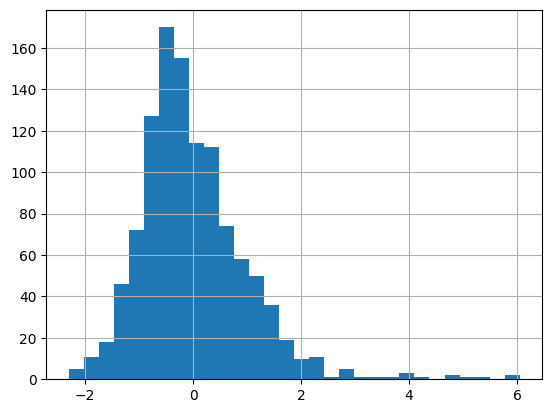

In [84]:
#Distribution of merged_df of alpha_z.
merged_df["alpha_z"].hist(bins=30)
plt.show()

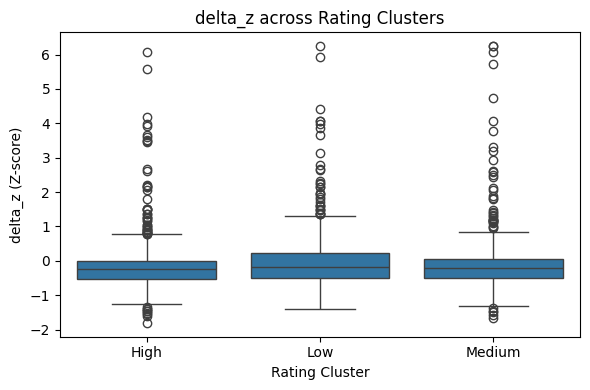

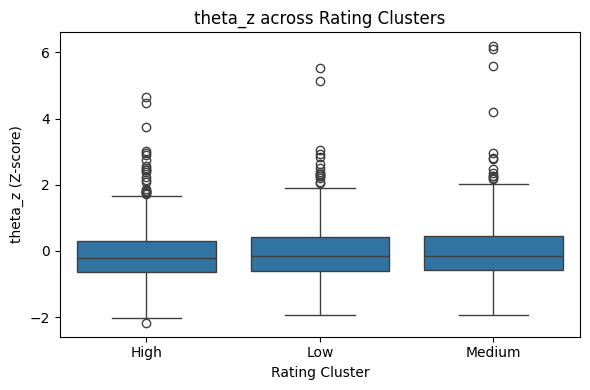

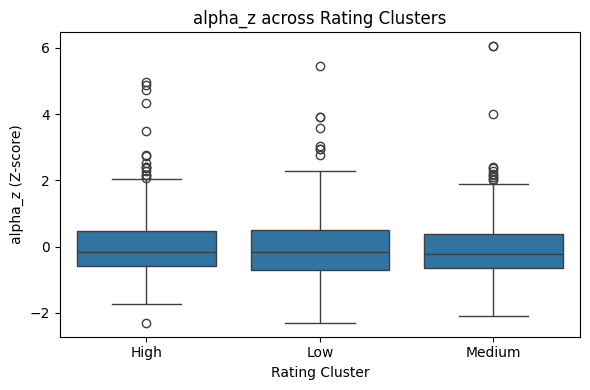

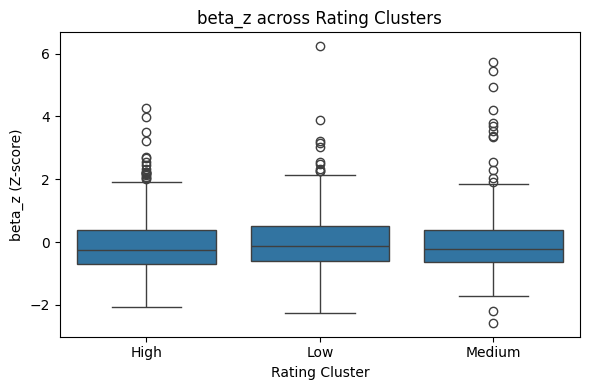

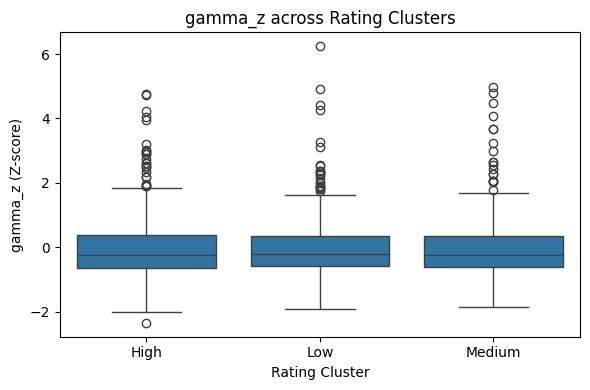

In [85]:
#Boxplots of Showing different bands and rating clusters.
bands = ["delta_z", "theta_z", "alpha_z", "beta_z", "gamma_z"]

for band in bands:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="rating_label", y=band, data=merged_df)
    plt.title(f"{band} across Rating Clusters")
    plt.xlabel("Rating Cluster")
    plt.ylabel(f"{band} (Z-score)")
    plt.tight_layout()
    plt.show()


In [46]:
from scipy.stats import f_oneway
for band in bands:
    groups = [merged_df[merged_df["rating_cluster"] == c][band] for c in [0,1,2]]
    f_stat, p = f_oneway(*groups)
    print(f"{band}: F = {f_stat:.2f}, p = {p:.4f}")


delta_z: F = 1.15, p = 0.3173
theta_z: F = 1.21, p = 0.2986
alpha_z: F = 0.99, p = 0.3716
beta_z: F = 0.73, p = 0.4844
gamma_z: F = 0.15, p = 0.8591


In [95]:
#t-test for happy vs not_happy for alpha bands

# category
happy_group = merged_df[merged_df["score"].isin([6, 7, 8, 9])]
not_happy_group = merged_df[merged_df["score"].isin([1, 2, 3, 4])]

# alpha
alpha_happy = happy_group["alpha_z"]
not_happy = not_happy_group["alpha_z"]

# Welch's t-test
t_stat, p_val = ttest_ind(alpha_happy, not_happy, equal_var=False)

print(f"T-statistic = {t_stat:.3f}")
print(f"P-value     = {p_val:.4f}")


T-statistic = -0.356
P-value     = 0.7221


Estimated degrees of freedom: 818.27


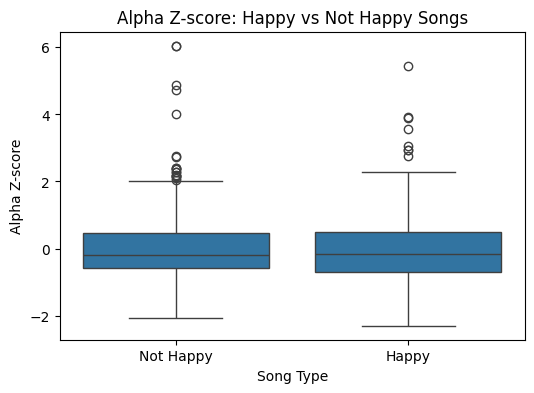

In [96]:
#degree of freedom
n1 = len(alpha_happy)
n2 = len(not_happy)

s1_sq = np.var(alpha_happy, ddof=1)
s2_sq = np.var(not_happy, ddof=1)

numerator = (s1_sq / n1 + s2_sq / n2) ** 2
denominator = ((s1_sq / n1)**2 / (n1 - 1)) + ((s2_sq / n2)**2 / (n2 - 1))
df = numerator / denominator

print(f"Estimated degrees of freedom: {df:.2f}")

#boxplot data visualization
merged_df["happy_song"] = merged_df["score"].apply(lambda x: "Happy" if x in [6,7,8,9] else
                                                              "Not Happy" if x in [1,2,3,4] else np.nan)

plt.figure(figsize=(6,4))
sns.boxplot(x="happy_song", y="alpha_z", data=merged_df)
plt.title("Alpha Z-score: Happy vs Not Happy Songs")
plt.ylabel("Alpha Z-score")
plt.xlabel("Song Type")
plt.show()


F = 1.182, p = 0.3065


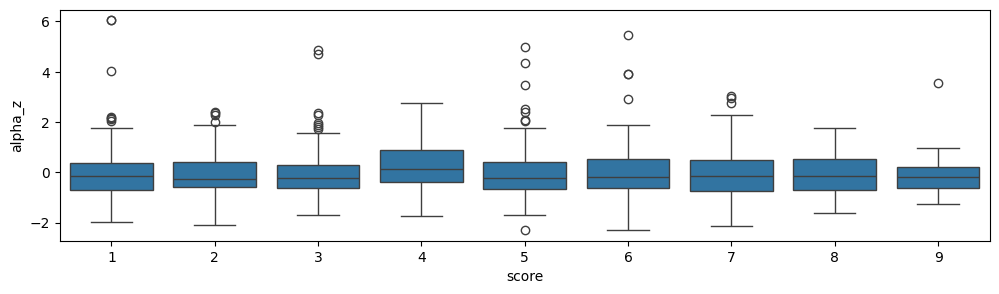

In [124]:
#ANOVA and The boxplot for all scores.

groups = [merged_df[merged_df["score"] == s]["alpha_z"].dropna() for s in range(1, 10)]
f_stat, p_val = f_oneway(*groups)
print(f"F = {f_stat:.3f}, p = {p_val:.4f}")

sns.boxplot(x="score", y="alpha_z", data=merged_df)
plt.show()

In [98]:
#Remove outliers
df_clean = merged_df[merged_df["alpha_z"].abs() < 3]
df_clean2 = df_clean[df_clean["beta_z"].abs()<3]
df_clean3 = df_clean2[df_clean2["delta_z"].abs()<3]
df_clean4 = df_clean3[df_clean3["theta_z"].abs()<3]
df_cleanf = df_clean4[df_clean4["gamma_z"].abs()<3]
df_cleanf

participant  run  song_index  song_time  question_index  question_time  \
0         sub-01    2           4      5.689               8         22.290   
1         sub-01    2          79     65.482             124        106.086   
2         sub-01    2         150    119.310             173        151.002   
3         sub-01    2         224    172.721             277        212.187   
4         sub-01    2         295    224.824             332        266.202   
...          ...  ...         ...        ...             ...            ...   
1101      sub-30    5         217    185.122             263        230.741   
1103      sub-30    5         364    303.030             401        340.073   
1104      sub-30    5         434    356.567             486        405.021   
1105      sub-30    5         503    417.895             548        466.002   
1106      sub-30    5         572    480.298             594        512.202   

      answer_index  answer_time  answer_code  rating  score  rating_cluster  \
0                9       22.290          903       3      3               0   
1              129      107.187          909       9      9               1   
2              177      151.603          907       7      7               1   
3              281      212.788          901       1      1               2   
4              335      266.402          901       1      1               2   
...            ...          ...          ...     ...    ...             ...   
1101           267      231.342          903       3      3               0   
1103           403      340.073          904       4      4               0   
1104           487      405.021          904       4      4               0   
1105           549      466.002          903       3      3               0   
1106           595      512.202          902       2      2               2   

      trial_index rating_label   delta_z   theta_z   alpha_z    beta_z  \
0               0         High  0.053831 -0.331996 -0.500455 -0.353110   
1               1          Low -0.157031 -0.110938 -0.484602 -0.482086   
2               2          Low -0.199911  0.093475 -0.172898 -0.179557   
3               3       Medium -0.217266 -0.496535 -0.505881 -0.465600   
4               4       Medium -0.210934 -0.075808  0.185562  0.213918   
...           ...          ...       ...       ...       ...       ...   
1101            3         High  0.350439 -0.437979  0.499875  0.306542   
1103            5         High -0.687376  0.171641  2.163577  1.205949   
1104            6         High -0.251571  0.138365  0.481819  0.228760   
1105            7         High -0.510824 -0.224753 -0.218481  0.827932   
1106            8       Medium -0.254799  2.478024 -0.705666  1.330408   

       gamma_z happy_song  
0    -0.269513  Not Happy  
1    -0.167954      Happy  
2    -0.329599      Happy  
3    -0.635380  Not Happy  
4    -0.619100  Not Happy  
...        ...        ...  
1101 -0.002964  Not Happy  
1103  0.462339  Not Happy  
1104  0.414712  Not Happy  
1105  0.420045  Not Happy  
1106  0.398639  Not Happy  

[1043 rows x 20 columns]

In [99]:
from scipy.stats import ttest_ind

#t-test for happy vs not_hppay for alpha bands after removing outliers.

# category
happy_group = df_cleanf[df_cleanf["score"].isin([6, 7, 8, 9])]
not_happy_group = df_cleanf[df_cleanf["score"].isin([1, 2, 3, 4])]

# alpha
alpha_happy = happy_group["alpha_z"]
not_happy = not_happy_group["alpha_z"]

# Welch's t-test
t_stat, p_val = ttest_ind(alpha_happy, not_happy, equal_var=False)

print(f"T-statistic = {t_stat:.3f}")
print(f"P-value     = {p_val:.4f}")


T-statistic = 0.021
P-value     = 0.9830


/tmp/ipykernel_2781416/3746732614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleanf["happy_song"] = df_cleanf["score"].apply(lambda x: "Happy" if x in [6,7,8,9] else


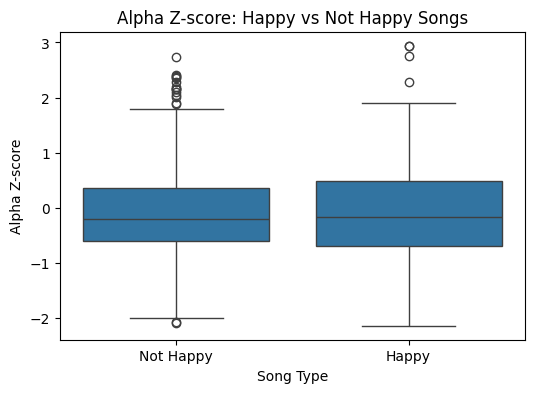

In [100]:
#The boxplot for two groups.
df_cleanf["happy_song"] = df_cleanf["score"].apply(lambda x: "Happy" if x in [6,7,8,9] else
                                                              "Not Happy" if x in [1,2,3,4] else np.nan)

plt.figure(figsize=(6,4))
sns.boxplot(x="happy_song", y="alpha_z", data=df_cleanf)
plt.title("Alpha Z-score: Happy vs Not Happy Songs")
plt.ylabel("Alpha Z-score")
plt.xlabel("Song Type")
plt.show()


In [102]:
# compare group1 and group9


# category
happy_group = df_cleanf[df_cleanf["score"].isin([9])]
not_happy_group = df_cleanf[df_cleanf["score"].isin([1])]

# alpha
alpha_happy = happy_group["alpha_z"]
not_happy = not_happy_group["alpha_z"]

# Welch's t-test
t_stat, p_val = ttest_ind(alpha_happy, not_happy, equal_var=False)

print(f"T-statistic = {t_stat:.3f}")
print(f"P-value     = {p_val:.4f}")


T-statistic = -0.912
P-value     = 0.3665


/tmp/ipykernel_2781416/3485422851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleanf["emotion_group"] = df_cleanf["score"].apply(lambda x: "Happy (9)" if x == 9 else ("Unhappy (1)" if x == 1 else np.nan))
/tmp/ipykernel_2781416/3485422851.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="emotion_group", y="alpha_z", data=plot_df, palette="Set2")


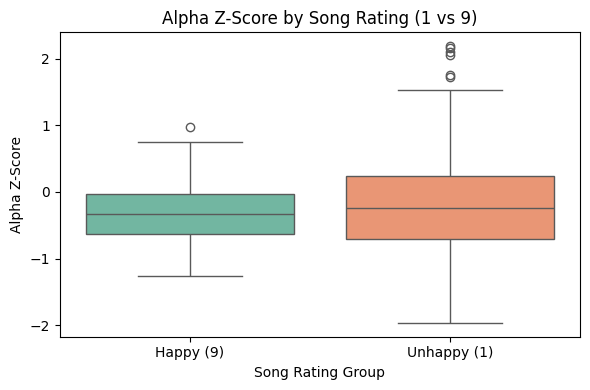

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cleanf["emotion_group"] = df_cleanf["score"].apply(lambda x: "Happy (9)" if x == 9 else ("Unhappy (1)" if x == 1 else np.nan))

plot_df = df_cleanf[df_cleanf["score"].isin([1, 9])]

#boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x="emotion_group", y="alpha_z", data=plot_df, palette="Set2")
plt.title("Alpha Z-Score by Song Rating (1 vs 9)")
plt.xlabel("Song Rating Group")
plt.ylabel("Alpha Z-Score")
plt.tight_layout()
plt.show()


In [104]:
#Degree of Freedom

n1 = len(alpha_happy)
n2 = len(not_happy)

s1_sq = np.var(alpha_happy, ddof=1)
s2_sq = np.var(not_happy, ddof=1)

numerator = (s1_sq / n1 + s2_sq / n2) ** 2
denominator = ((s1_sq / n1)**2 / (n1 - 1)) + ((s2_sq / n2)**2 / (n2 - 1))
df = numerator / denominator

print(f"Estimated degrees of freedom: {df:.2f}")


Estimated degrees of freedom: 45.19


In [105]:
#T-test for all brain bands.
for band in ["alpha_z", "beta_z", "gamma_z", "theta_z", "delta_z"]:
    happy = happy_group[band]
    not_happy = not_happy_group[band]
    t_stat, p_val = ttest_ind(happy, not_happy, equal_var=False)
    print(f"{band}: T = {t_stat:.2f}, p = {p_val:.4f}")


alpha_z: T = -0.91, p = 0.3665
beta_z: T = 0.50, p = 0.6214
gamma_z: T = -1.47, p = 0.1494
theta_z: T = -0.81, p = 0.4254
delta_z: T = 1.17, p = 0.2519


**Logistic Regression and Multinomial Regression**

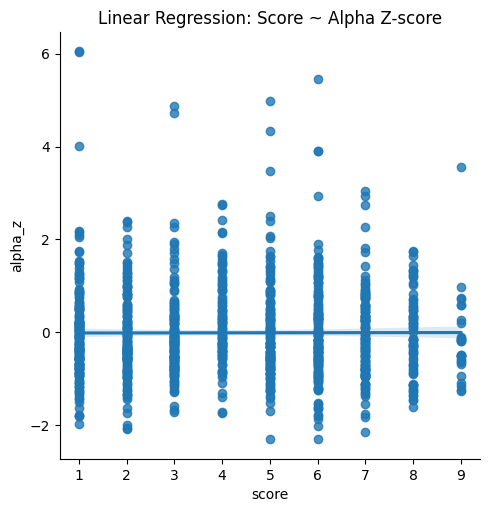

In [57]:
sns.lmplot(x="score", y="alpha_z", data=merged_df)
plt.title("Linear Regression: Score ~ Alpha Z-score")
plt.show()


In [56]:
#since it's categorical, we can do the lositic regression.

merged_df["is_happy"] = merged_df["score"].apply(lambda x: 1 if x in [6, 7, 8, 9] else
                                                            0 if x in [1, 2, 3, 4] else np.nan)
logit_df = merged_df.dropna(subset=["is_happy", "alpha_z", "beta_z", "gamma_z", "theta_z", "delta_z"])

import statsmodels.api as sm

X = logit_df[["alpha_z", "beta_z", "gamma_z", "theta_z", "delta_z"]]
X = sm.add_constant(X) 
y = logit_df["is_happy"]

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.671196
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               is_happy   No. Observations:                  966
Model:                          Logit   Df Residuals:                      960
Method:                           MLE   Df Model:                            5
Date:                Sun, 11 May 2025   Pseudo R-squ.:                0.002448
Time:                        16:46:40   Log-Likelihood:                -648.38
converged:                       True   LL-Null:                       -649.97
Covariance Type:            nonrobust   LLR p-value:                    0.6719
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4106      0.066     -6.233      0.000      -0.540      -0.281
alpha_z       -0.0854      0.

In [58]:
#Multinomial Regression

features = ["alpha_z", "beta_z", "gamma_z", "theta_z", "delta_z"]
X1 = merged_df[features]
y1 = merged_df["rating_label"]

X_scaled1 = X1.copy() 


X_const1 = sm.add_constant(X_scaled1)


mnlogit_model1 = sm.MNLogit(y1, X_const1)
result1 = mnlogit_model1.fit()

print(result1.summary())


Optimization terminated successfully.
         Current function value: 1.090445
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:           rating_label   No. Observations:                 1107
Model:                        MNLogit   Df Residuals:                     1095
Method:                           MLE   Df Model:                           10
Date:                Sun, 11 May 2025   Pseudo R-squ.:                0.005240
Time:                        16:49:04   Log-Likelihood:                -1207.1
converged:                       True   LL-Null:                       -1213.5
Covariance Type:            nonrobust   LLR p-value:                    0.2400
   rating_label=Low       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0008      0.072      0.011      0.991      -0.141       0.143
al

**Spliting data into Up 25% and Bottom 25%**

In [59]:
# 25% and 75%
q25 = merged_df["rating"].quantile(0.25)
q75 = merged_df["rating"].quantile(0.75)

# select data
low_group = merged_df[merged_df["rating"] <= q25]
high_group = merged_df[merged_df["rating"] >= q75]

# alpha_z t-test ：
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(high_group["alpha_z"], low_group["alpha_z"], equal_var=False)
print(f"T-statistic = {t_stat:.3f}, P-value = {p_val:.4f}")


T-statistic = 0.360, P-value = 0.7186


In [60]:
#calculating df

n1 = len(high_group)
n2 = len(low_group)

s1_sq = np.var(high_group["alpha_z"], ddof=1)
s2_sq = np.var(low_group["alpha_z"], ddof=1)

numerator = (s1_sq / n1 + s2_sq / n2) ** 2
denominator = ((s1_sq / n1) ** 2) / (n1 - 1) + ((s2_sq / n2) ** 2) / (n2 - 1)
df = numerator / denominator

print(f"Estimated df: {df:.2f}")


Estimated df: 700.29


/tmp/ipykernel_2781416/1208972071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_group["group"] = "Low (≤ 25%)"
/tmp/ipykernel_2781416/1208972071.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_group["group"] = "High (≥ 75%)"
/tmp/ipykernel_2781416/1208972071.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="group", y="alpha_z", data=pl

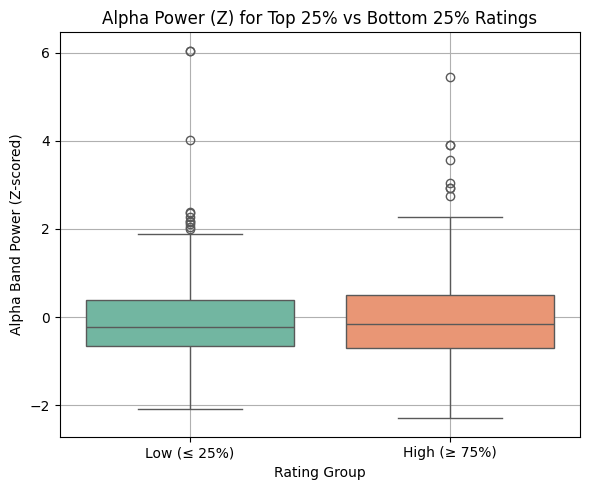

In [61]:
#Boxplot for the low and high group.

low_group["group"] = "Low (≤ 25%)"
high_group["group"] = "High (≥ 75%)"

plot_df = pd.concat([low_group, high_group])

plt.figure(figsize=(6, 5))
sns.boxplot(x="group", y="alpha_z", data=plot_df, palette="Set2")
plt.title("Alpha Power (Z) for Top 25% vs Bottom 25% Ratings")
plt.ylabel("Alpha Band Power (Z-scored)")
plt.xlabel("Rating Group")
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis on full PSD**

In [62]:
#Standardized full PSDs

import scipy as sp
features_zscore =[]
features_dB = []
# -----sub-01 to sub-32-----
for subj_id in subject_ids:
    print(np.where(subject_id_array == subj_id))
    this_psd = final_features[np.where(subject_id_array == subj_id), :]
    this_psds = this_psd.squeeze()
    # mean = this_psd.mean()
    # this_psd- mean
    
    this_zscore = sp.stats.zscore(this_psds, axis=0)

    this_dB = np.log(this_psds) - np.log(this_psds.mean())

    # if this_zscore is not None and this_zscore.size > 0:
        # if np.any(this_zscore > 5):
        #     this_zscore[i, :] = np.nan
  
    features_zscore.append(this_zscore)

    features_dB.append((this_dB))

final_zscore = np.vstack(features_zscore)  
final_db = np.vstack(features_dB)  



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]),)
(array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79]),)
(array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119]),)
(array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159]),)
(array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188,

In [106]:
participants = [f"sub-{i:02d}" for i in range(1, 32) if i != 9] 
index_list = []

for p in participants:
    for r in range(2, 6):  # run2 to run5
        for t_idx in range(10):  # 10 trials per run
            index_list.append((p, r, t_idx))

index_df = pd.DataFrame(index_list, columns=["participant", "run", "trial_index"])
# shape = (1240, 721)
psd_df = pd.DataFrame(final_zscore, columns=[f"freq_{i}" for i in range(721)])

full_psd_df = pd.concat([index_df, psd_df], axis=1)
full_psd_df.head()

participant  run  trial_index    freq_0    freq_1    freq_2    freq_3  \
0      sub-01    2            0  0.150037  0.126421  0.128198  0.166299   
1      sub-01    2            1 -0.132082 -0.136966 -0.133915 -0.127784   
2      sub-01    2            2 -0.213764 -0.210325 -0.209395 -0.220337   
3      sub-01    2            3 -0.211505 -0.208568 -0.208142 -0.222919   
4      sub-01    2            4 -0.210243 -0.207337 -0.204327 -0.214657   

     freq_4    freq_5    freq_6  ...  freq_711  freq_712  freq_713  freq_714  \
0  0.104666 -0.119862 -0.155854  ... -0.039944 -0.087461 -0.059861 -0.257675   
1 -0.143961 -0.193006 -0.194030  ... -0.212601 -0.278204  0.033758  0.231992   
2 -0.205315 -0.180837 -0.168869  ... -0.340738 -0.161185 -0.331430 -0.015670   
3 -0.208575 -0.189245 -0.187455  ... -0.639298 -0.608746 -0.528689 -0.649800   
4 -0.205626 -0.183815 -0.177667  ... -0.721280 -0.709376 -0.754058 -0.765781   

   freq_715  freq_716  freq_717  freq_718  freq_719  freq_720  
0 -0.330317 -0.203473 -0.076160 -0.313706 -0.304812 -0.202387  
1  0.480422  0.235110 -0.033713  0.022757  0.107820  0.017544  
2  0.072609 -0.063741 -0.012740 -0.223293 -0.248905 -0.295545  
3 -0.678121 -0.556907 -0.715576 -0.634249 -0.641339 -0.700960  
4 -0.684366 -0.721598 -0.723579 -0.751374 -0.738534 -0.701574  

[5 rows x 724 columns]

In [107]:
merged_psddf = pd.merge(full_psd_df, happy_df, on=["participant", "run", "trial_index"])
merged_psddf

participant  run  trial_index    freq_0    freq_1    freq_2    freq_3  \
0         sub-01    2            0  0.150037  0.126421  0.128198  0.166299   
1         sub-01    2            1 -0.132082 -0.136966 -0.133915 -0.127784   
2         sub-01    2            2 -0.213764 -0.210325 -0.209395 -0.220337   
3         sub-01    2            3 -0.211505 -0.208568 -0.208142 -0.222919   
4         sub-01    2            4 -0.210243 -0.207337 -0.204327 -0.214657   
...          ...  ...          ...       ...       ...       ...       ...   
1102      sub-30    5            4  1.890414  2.040969  1.710623  2.128521   
1103      sub-30    5            5 -0.445110 -0.482506 -0.495680 -0.583273   
1104      sub-30    5            6 -0.264525 -0.203626 -0.181512 -0.338484   
1105      sub-30    5            7 -0.570245 -0.576493 -0.645936 -0.633438   
1106      sub-30    5            8 -0.371279 -0.357680 -0.598688 -0.472228   

        freq_4    freq_5    freq_6  ...  song_time  question_index  \
0     0.104666 -0.119862 -0.155854  ...      5.689               8   
1    -0.143961 -0.193006 -0.194030  ...     65.482             124   
2    -0.205315 -0.180837 -0.168869  ...    119.310             173   
3    -0.208575 -0.189245 -0.187455  ...    172.721             277   
4    -0.205626 -0.183815 -0.177667  ...    224.824             332   
...        ...       ...       ...  ...        ...             ...   
1102  2.260802  3.687525  4.545211  ...    247.304             333   
1103 -0.512171 -0.431589 -0.407461  ...    303.030             401   
1104 -0.184808  0.170466 -0.212416  ...    356.567             486   
1105 -0.591051 -0.260194 -0.289882  ...    417.895             548   
1106 -0.254845  1.114933  0.999135  ...    480.298             594   

      question_time  answer_index  answer_time  answer_code  rating  score  \
0            22.290             9       22.290          903       3      3   
1           106.086           129      107.187          909       9      9   
2           151.002           177      151.603          907       7      7   
3           212.187           281      212.788          901       1      1   
4           266.202           335      266.402          901       1      1   
...             ...           ...          ...          ...     ...    ...   
1102        285.802           335      285.802          904       4      4   
1103        340.073           403      340.073          904       4      4   
1104        405.021           487      405.021          904       4      4   
1105        466.002           549      466.002          903       3      3   
1106        512.202           595      512.202          902       2      2   

      rating_cluster  rating_label  
0                  0          High  
1                  1           Low  
2                  1           Low  
3                  2        Medium  
4                  2        Medium  
...              ...           ...  
1102               0          High  
1103               0          High  
1104               0          High  
1105               0          High  
1106               2        Medium  

[1107 rows x 735 columns]

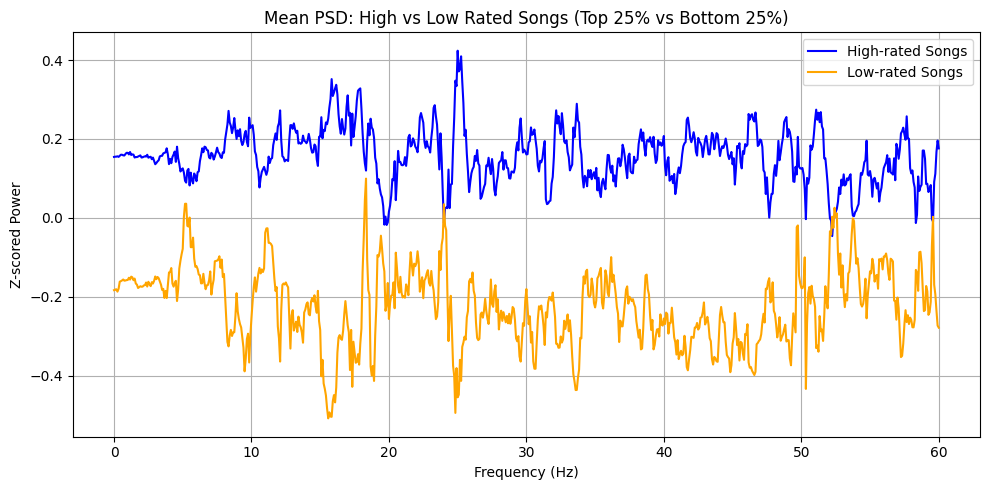

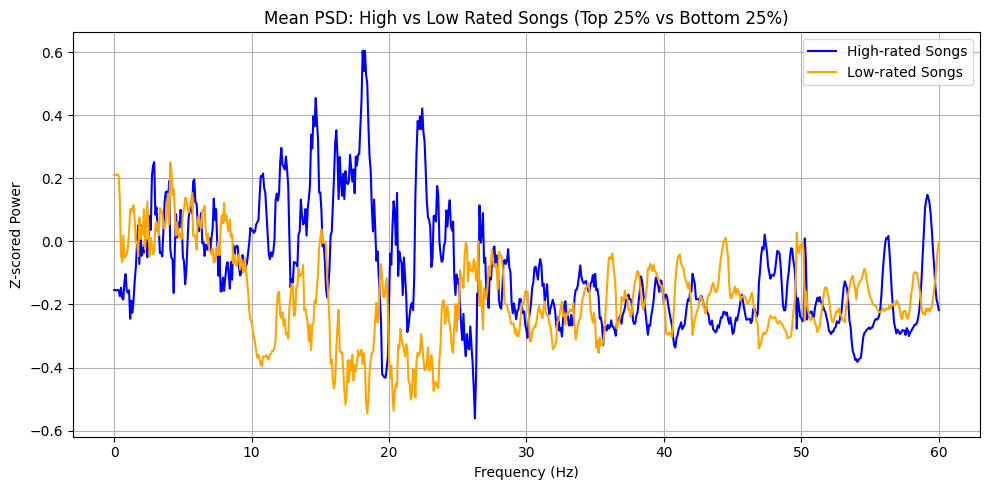

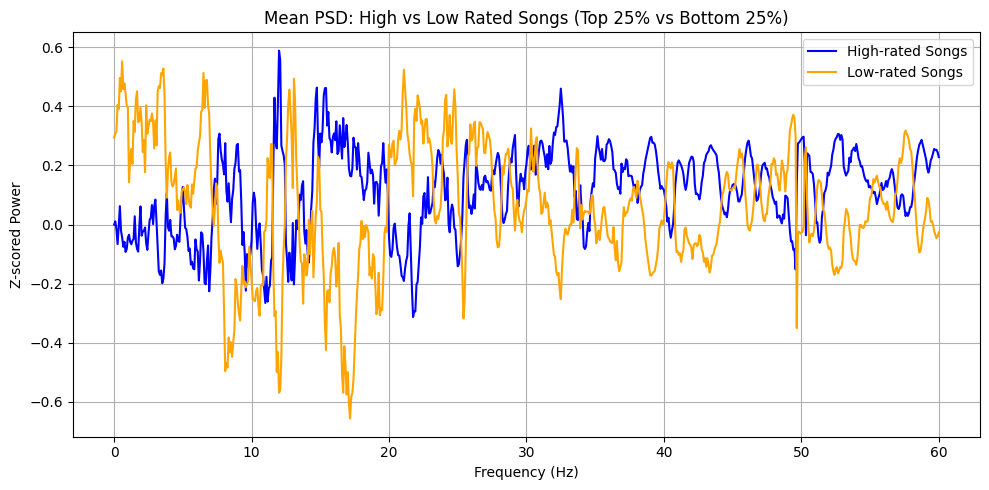

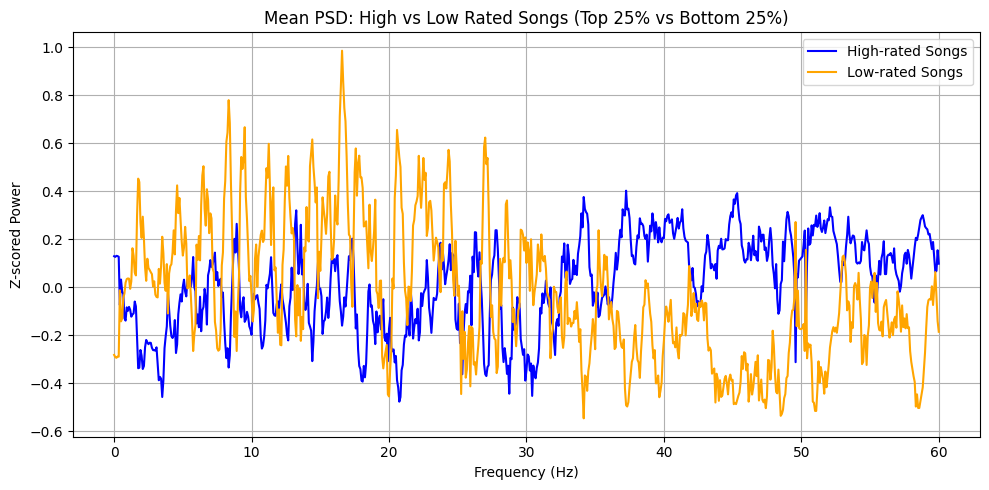

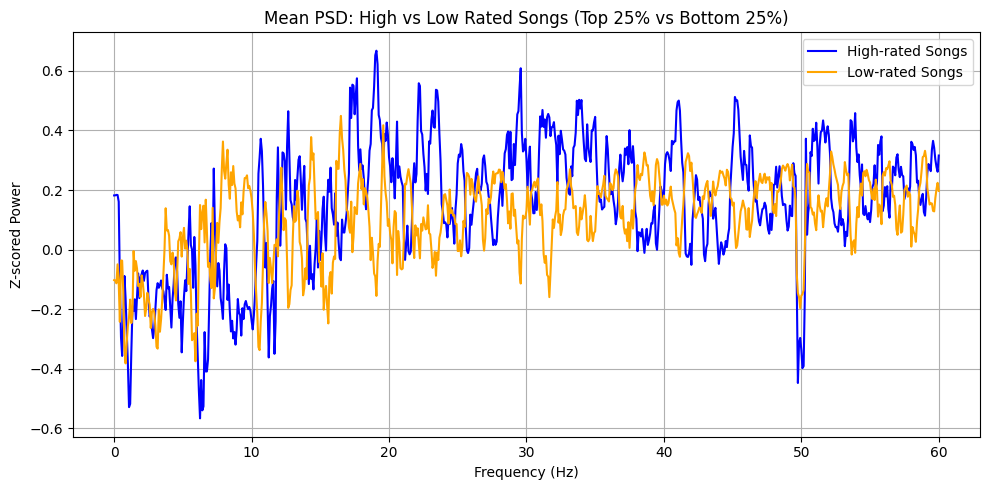

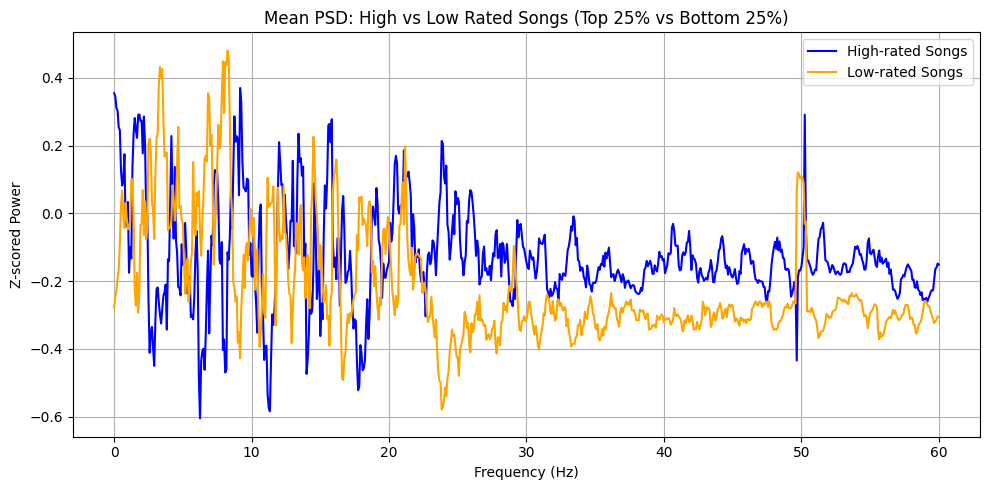

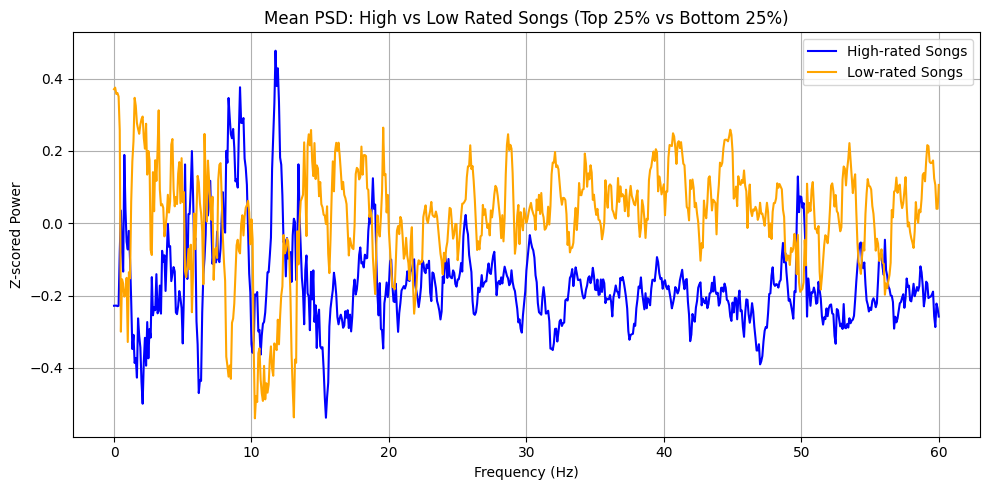

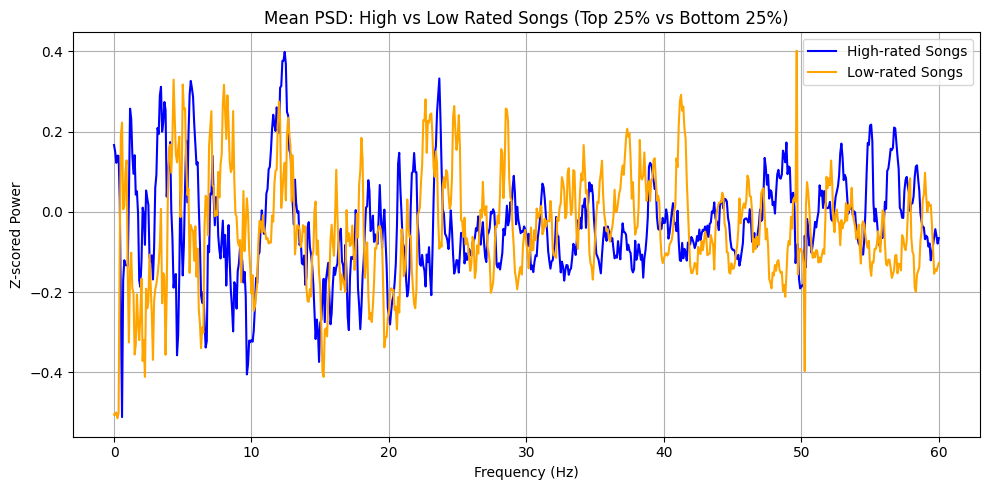

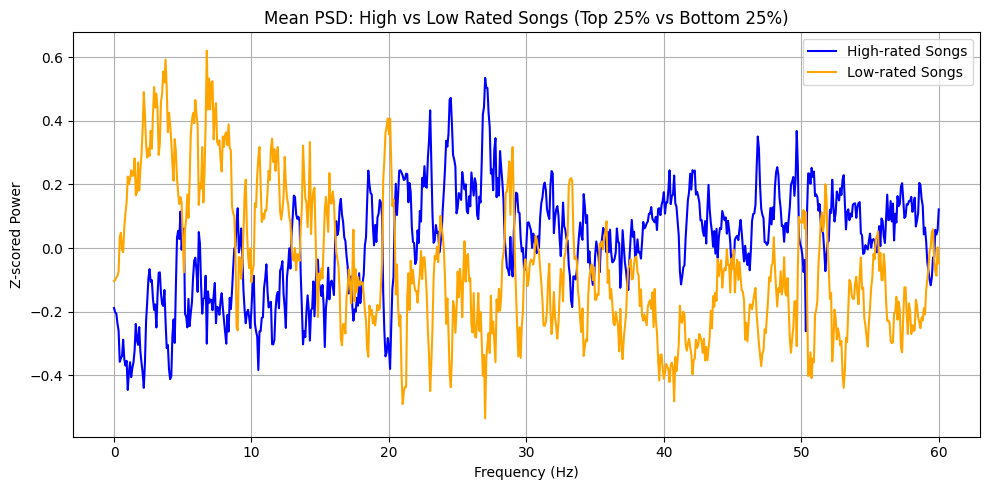

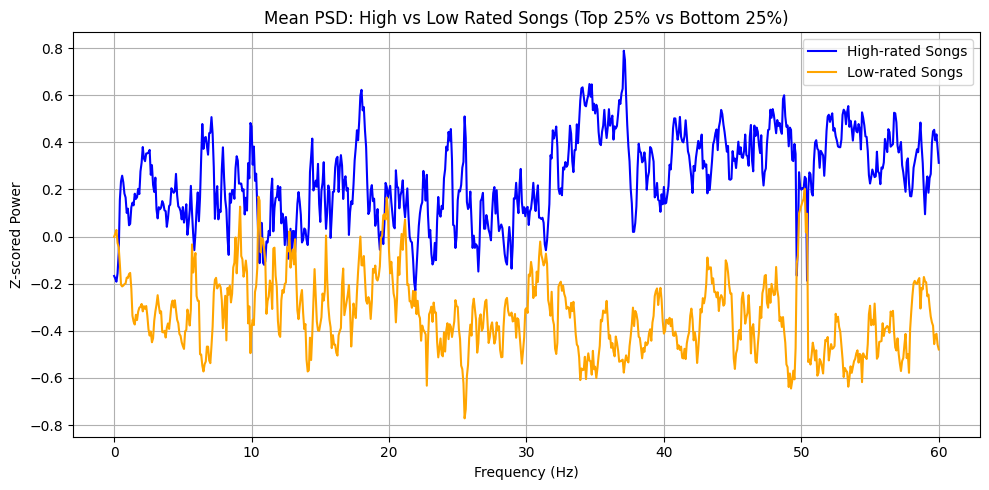

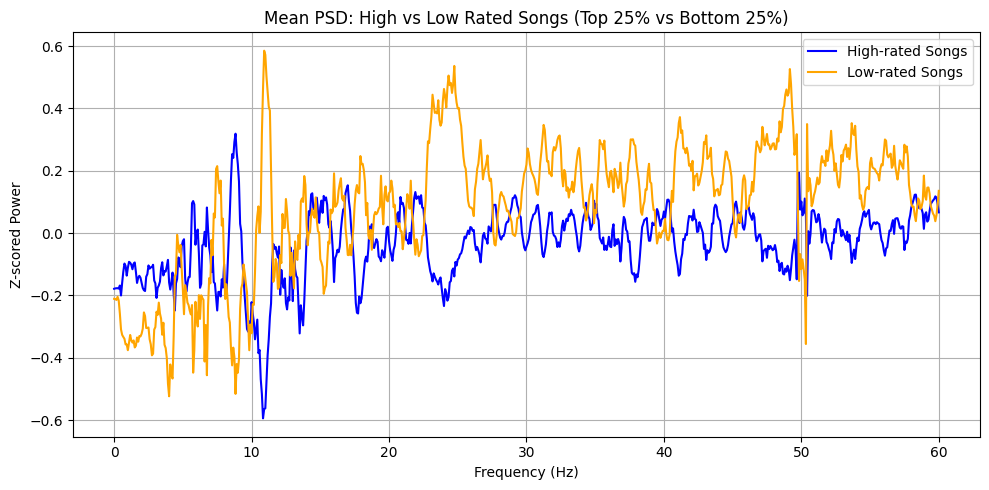

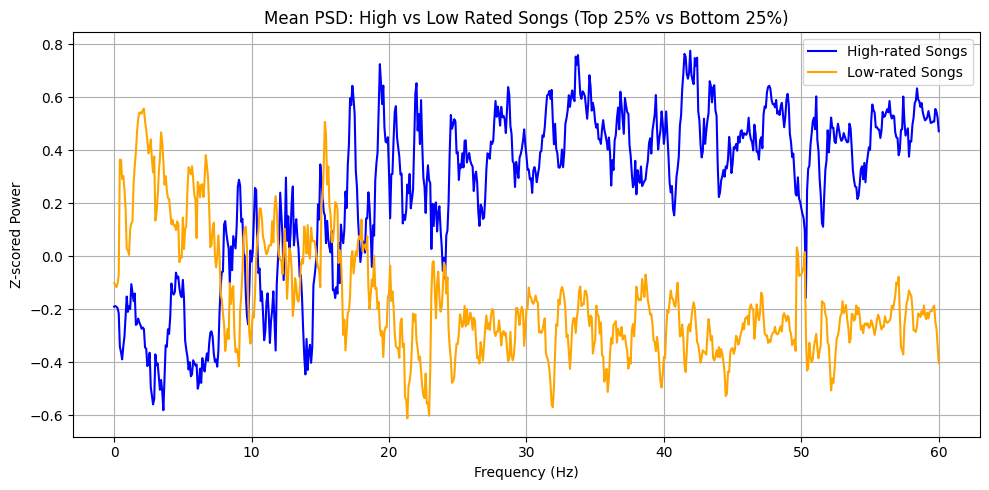

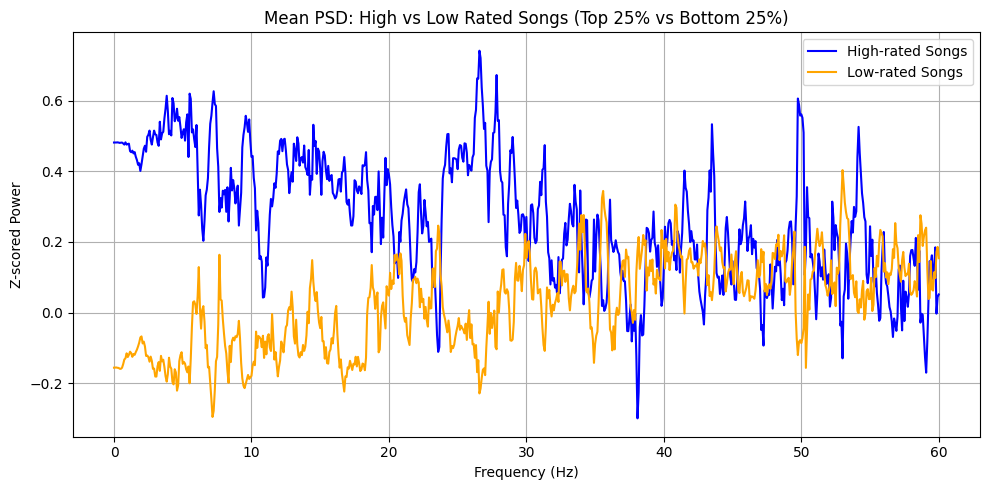

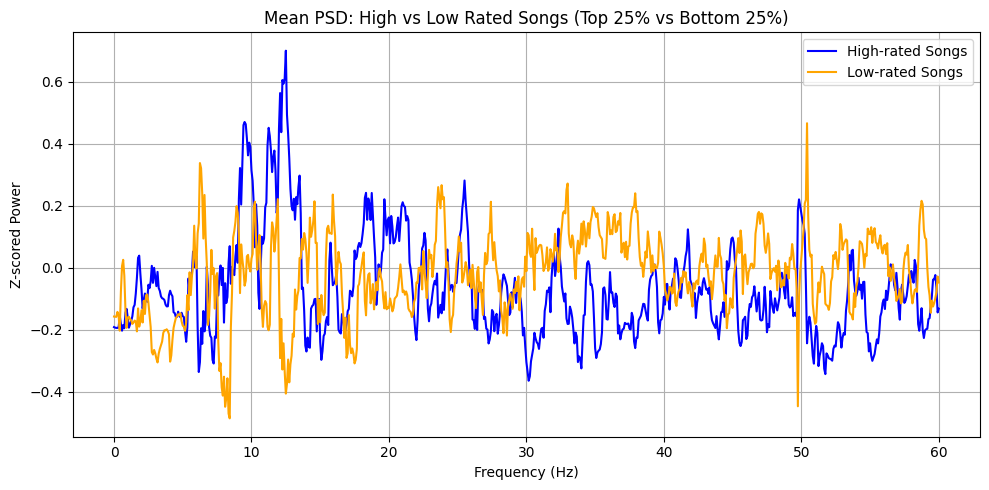

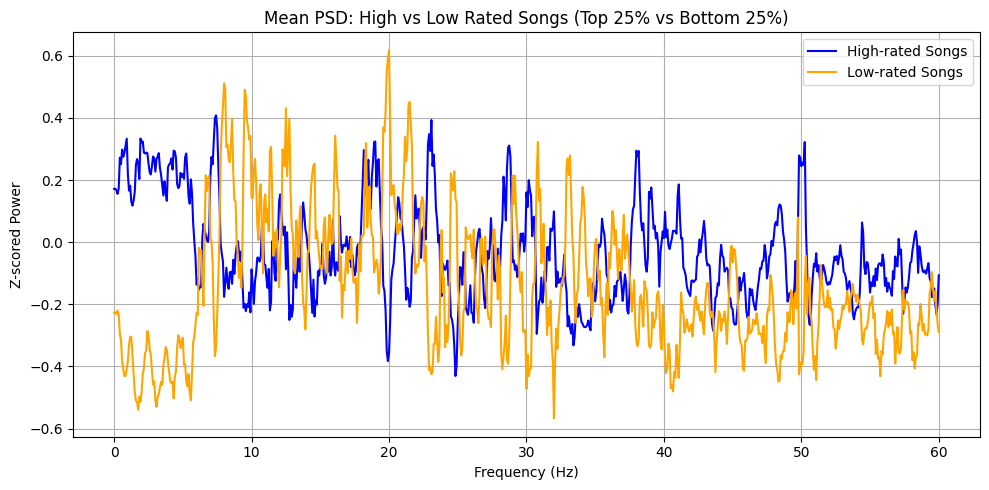

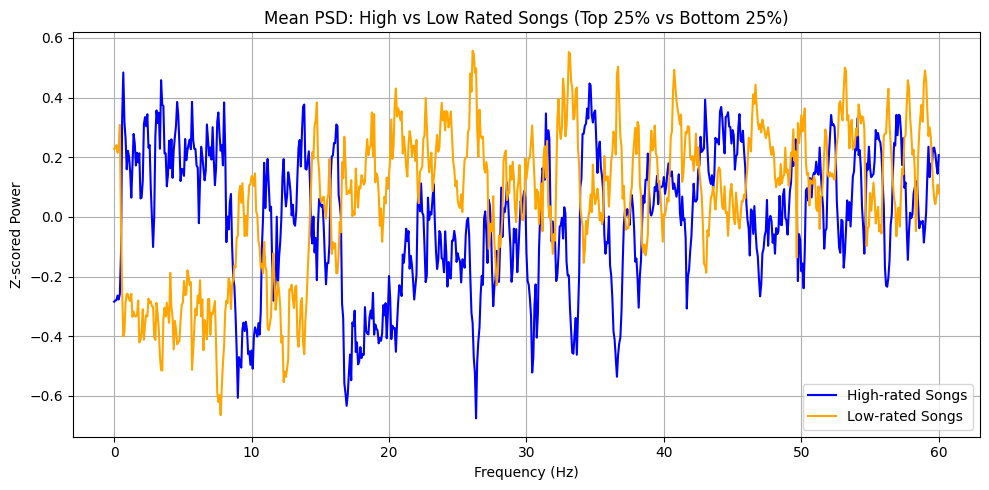

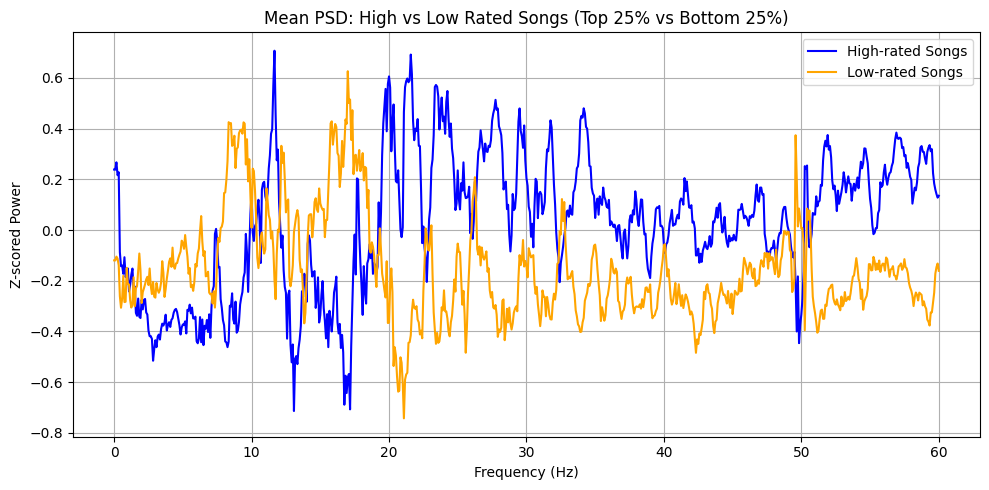

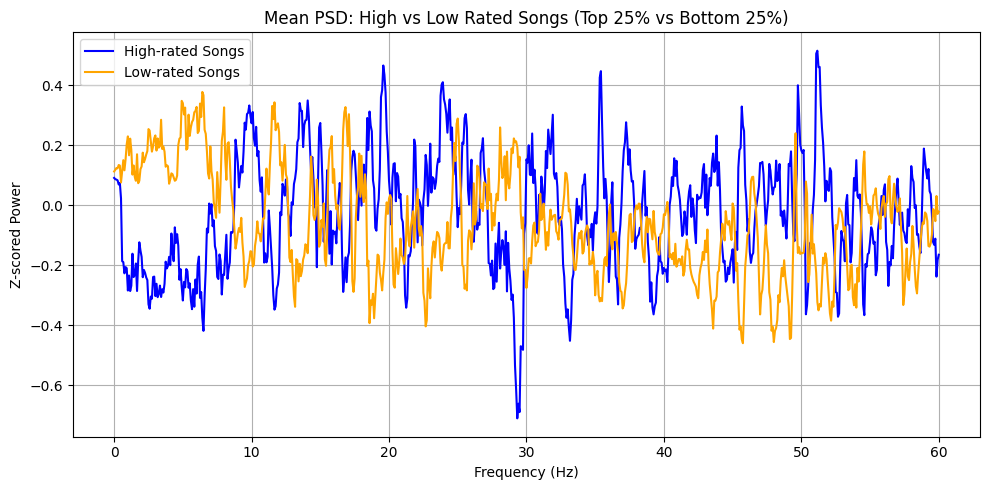

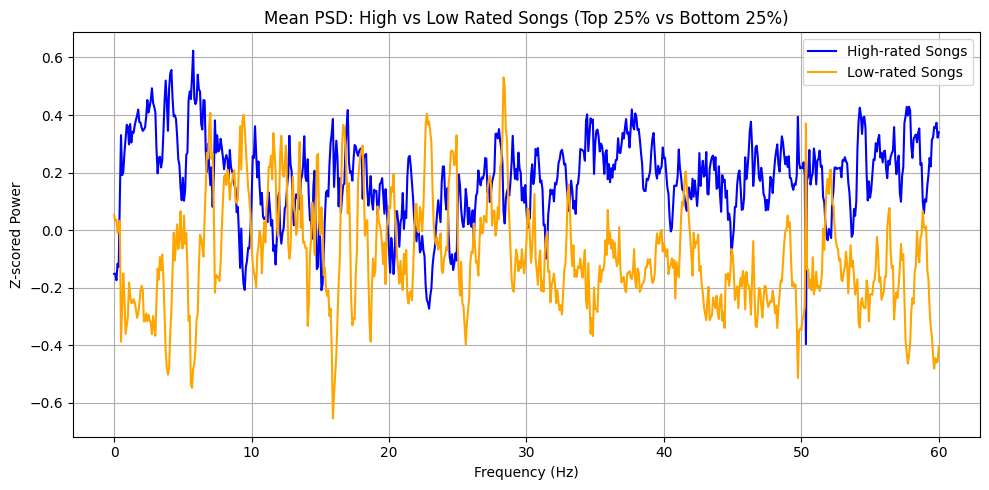

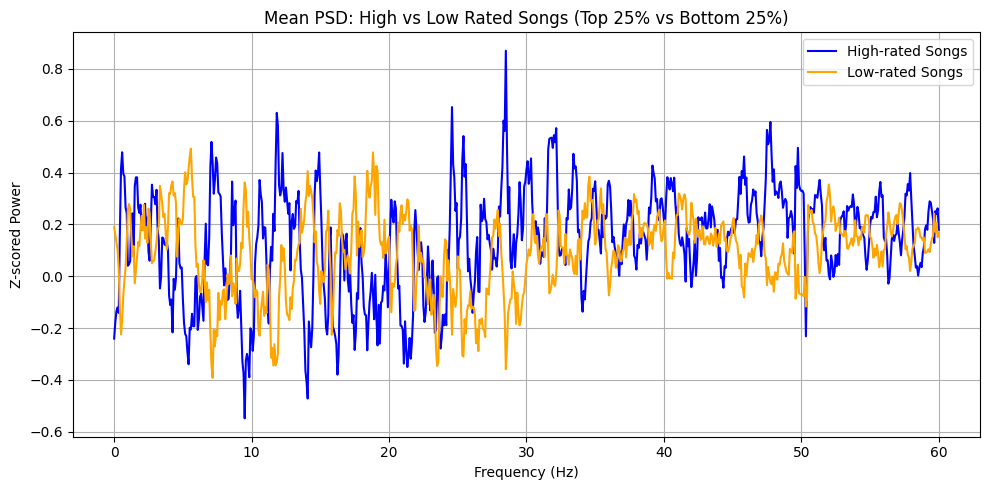

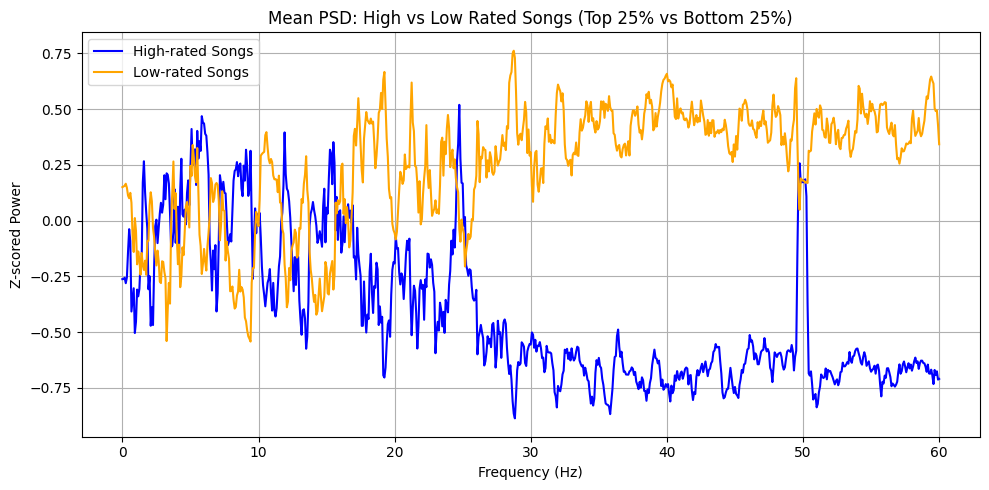

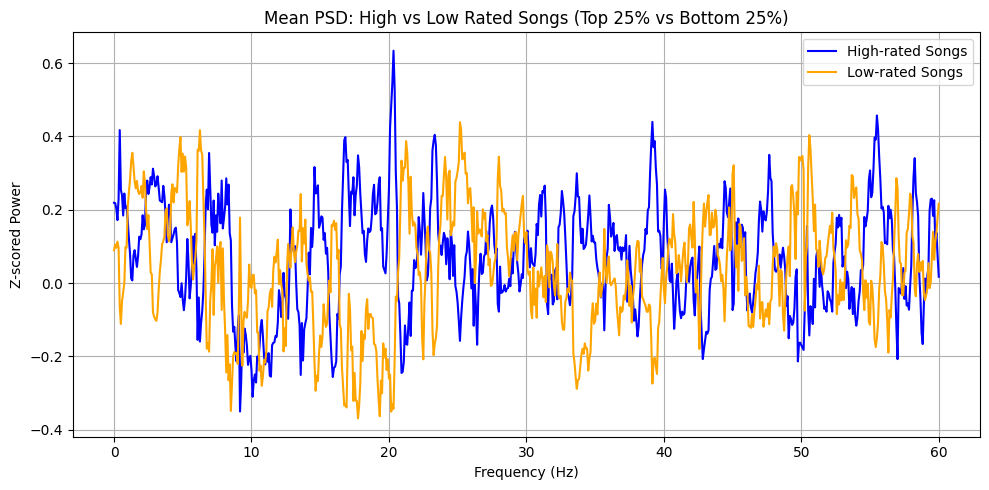

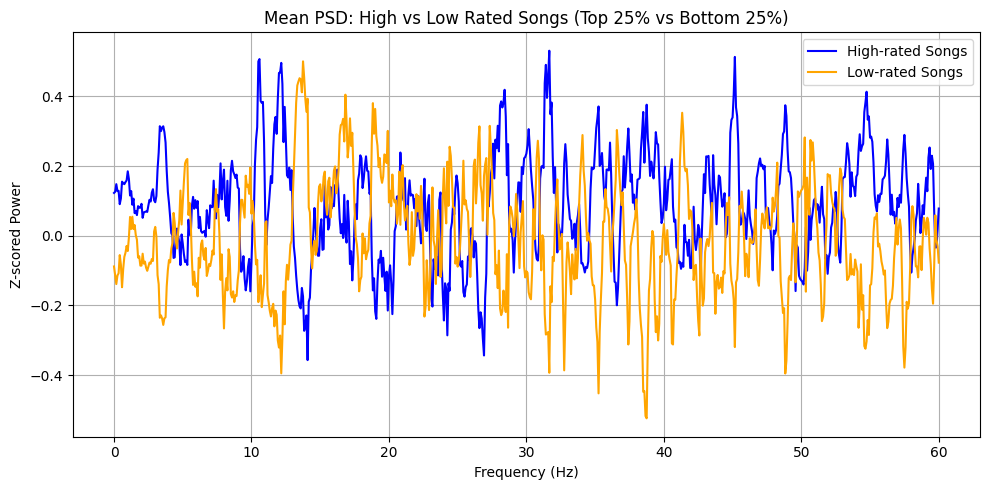

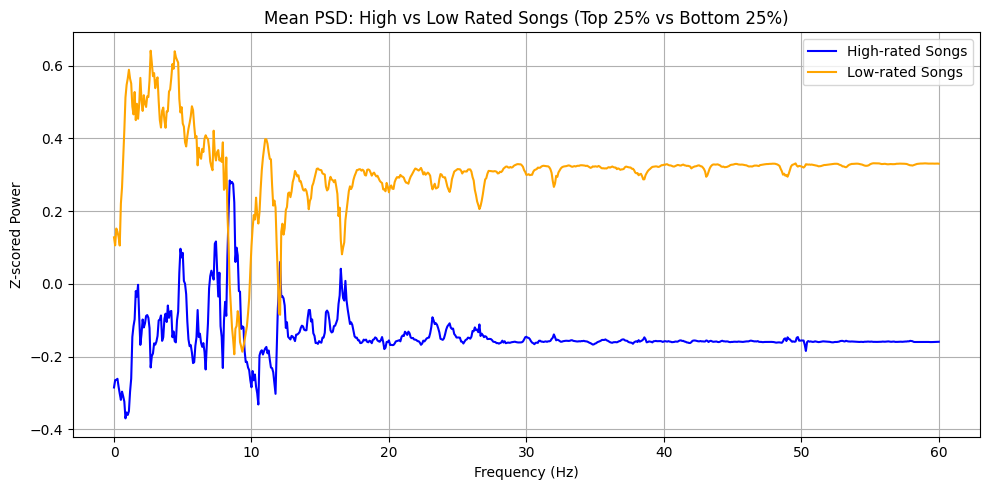

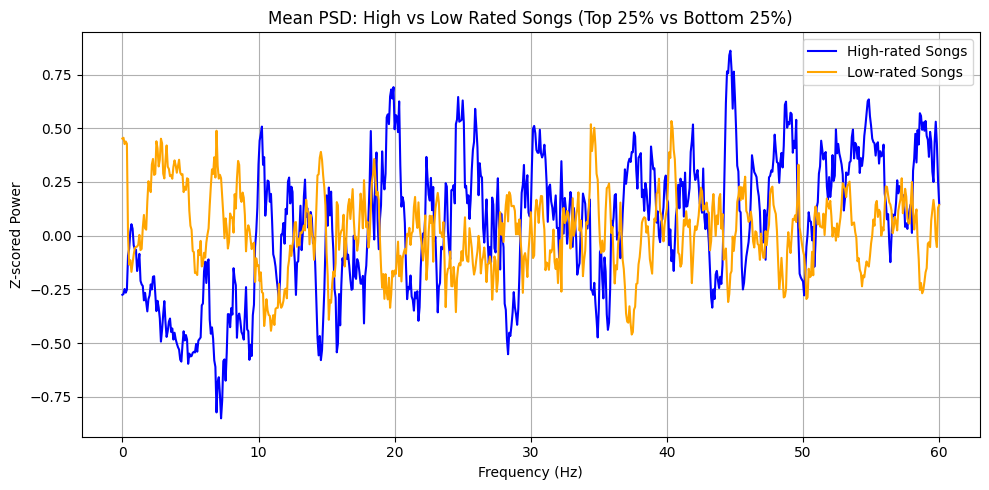

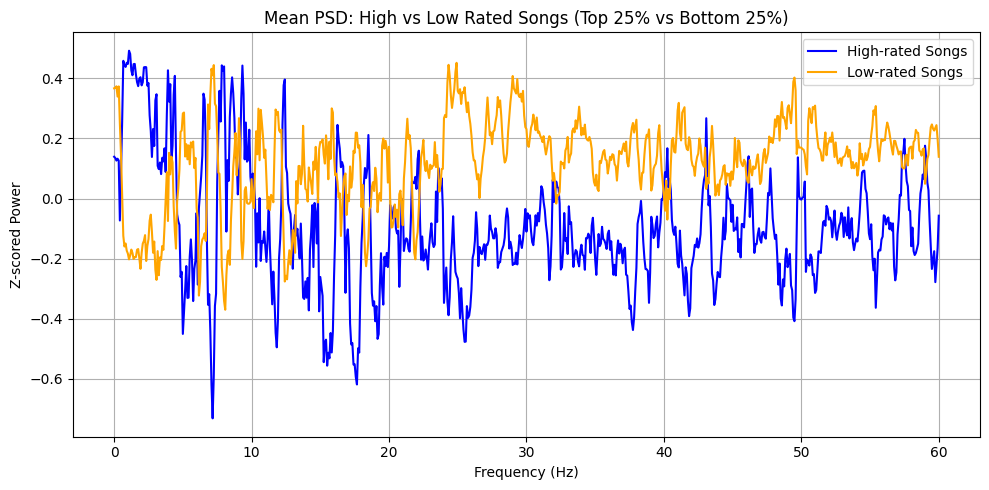

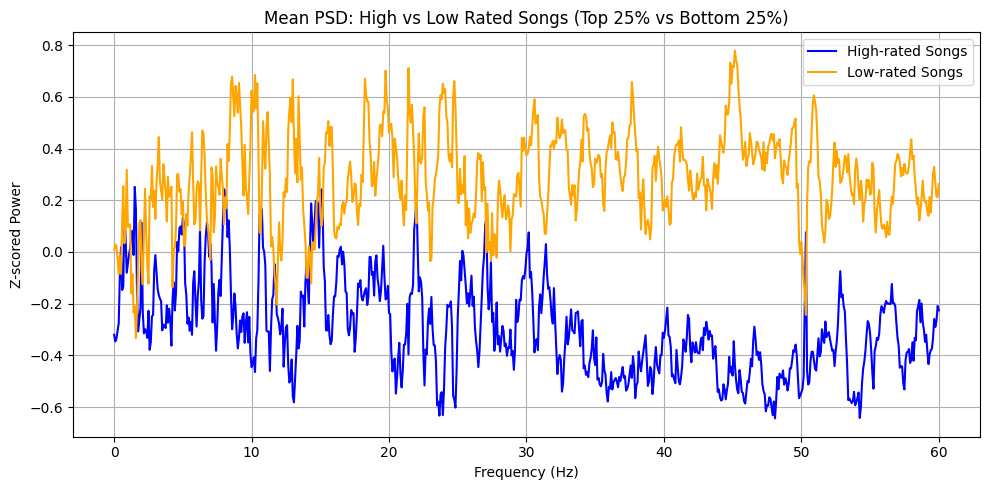

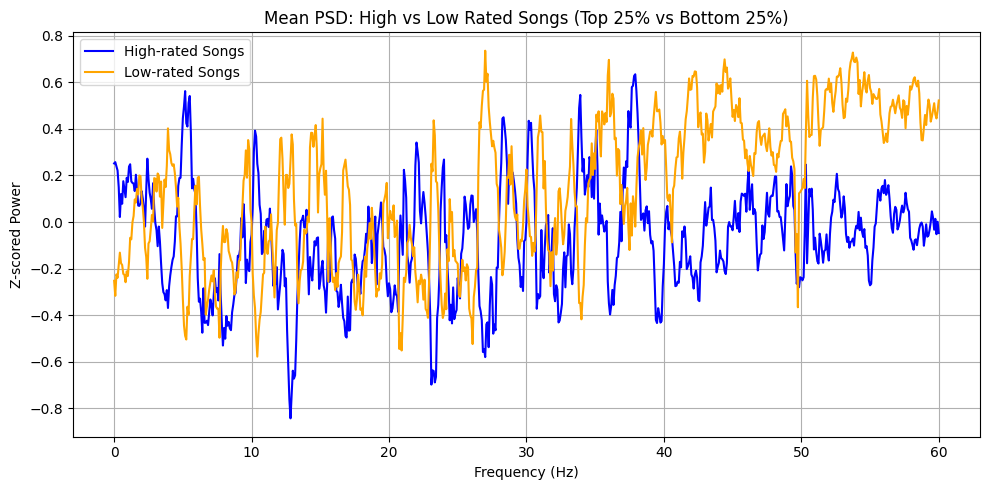

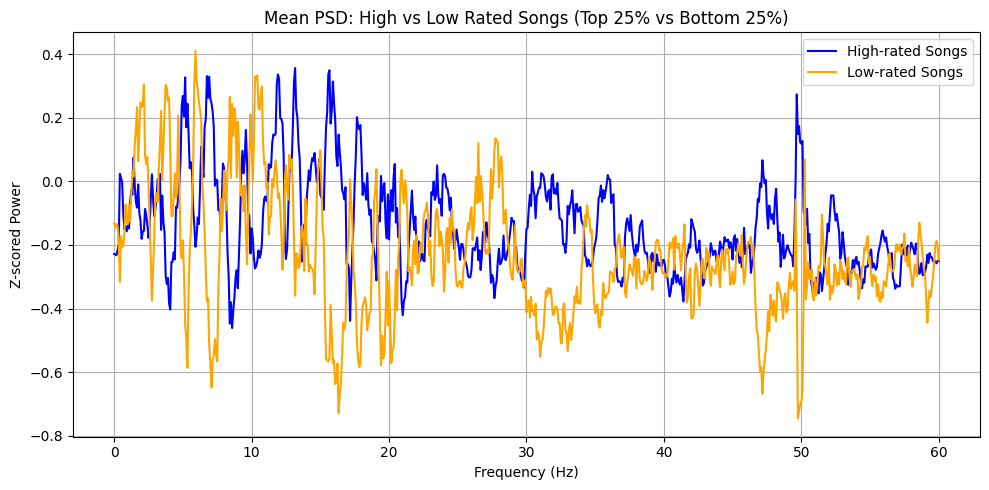

In [112]:
all_high_psd = []
all_low_psd = []

for pid in merged_psddf["participant"].unique():
    person_df = merged_psddf[merged_psddf["participant"] == pid]
    
    
    q25 = person_df["rating"].quantile(0.25)
    q75 = person_df["rating"].quantile(0.75)

    low_songs = person_df[person_df["rating"] <= q25]
    high_songs = person_df[person_df["rating"] >= q75]


    freq_cols = [col for col in person_df.columns if col.startswith("freq_")]

    # mean PSD across songs for each group
    low_mean = low_songs[freq_cols].mean(axis=0)
    high_mean = high_songs[freq_cols].mean(axis=0)

    
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, low_mean, label="High-rated Songs", color="blue")
    plt.plot(freqs, high_mean, label="Low-rated Songs", color="orange")

    plt.title("Mean PSD: High vs Low Rated Songs (Top 25% vs Bottom 25%)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Z-scored Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    all_low_psd.append(low_mean.values)
    all_high_psd.append(high_mean.values)

import numpy as np

group_low = np.mean(all_low_psd, axis=0)
group_high = np.mean(all_high_psd, axis=0)

In [113]:
merged_psddf["is_happy"] = merged_psddf["score"].apply(lambda x: 1 if x >= 6 else 0)
merged_psddf

participant  run  trial_index    freq_0    freq_1    freq_2    freq_3  \
0         sub-01    2            0  0.150037  0.126421  0.128198  0.166299   
1         sub-01    2            1 -0.132082 -0.136966 -0.133915 -0.127784   
2         sub-01    2            2 -0.213764 -0.210325 -0.209395 -0.220337   
3         sub-01    2            3 -0.211505 -0.208568 -0.208142 -0.222919   
4         sub-01    2            4 -0.210243 -0.207337 -0.204327 -0.214657   
...          ...  ...          ...       ...       ...       ...       ...   
1102      sub-30    5            4  1.890414  2.040969  1.710623  2.128521   
1103      sub-30    5            5 -0.445110 -0.482506 -0.495680 -0.583273   
1104      sub-30    5            6 -0.264525 -0.203626 -0.181512 -0.338484   
1105      sub-30    5            7 -0.570245 -0.576493 -0.645936 -0.633438   
1106      sub-30    5            8 -0.371279 -0.357680 -0.598688 -0.472228   

        freq_4    freq_5    freq_6  ...  question_index  question_time  \
0     0.104666 -0.119862 -0.155854  ...               8         22.290   
1    -0.143961 -0.193006 -0.194030  ...             124        106.086   
2    -0.205315 -0.180837 -0.168869  ...             173        151.002   
3    -0.208575 -0.189245 -0.187455  ...             277        212.187   
4    -0.205626 -0.183815 -0.177667  ...             332        266.202   
...        ...       ...       ...  ...             ...            ...   
1102  2.260802  3.687525  4.545211  ...             333        285.802   
1103 -0.512171 -0.431589 -0.407461  ...             401        340.073   
1104 -0.184808  0.170466 -0.212416  ...             486        405.021   
1105 -0.591051 -0.260194 -0.289882  ...             548        466.002   
1106 -0.254845  1.114933  0.999135  ...             594        512.202   

      answer_index  answer_time  answer_code  rating  score  rating_cluster  \
0                9       22.290          903       3      3               0   
1              129      107.187          909       9      9               1   
2              177      151.603          907       7      7               1   
3              281      212.788          901       1      1               2   
4              335      266.402          901       1      1               2   
...            ...          ...          ...     ...    ...             ...   
1102           335      285.802          904       4      4               0   
1103           403      340.073          904       4      4               0   
1104           487      405.021          904       4      4               0   
1105           549      466.002          903       3      3               0   
1106           595      512.202          902       2      2               2   

      rating_label  is_happy  
0             High         0  
1              Low         1  
2              Low         1  
3           Medium         0  
4           Medium         0  
...            ...       ...  
1102          High         0  
1103          High         0  
1104          High         0  
1105          High         0  
1106        Medium         0  

[1107 rows x 736 columns]

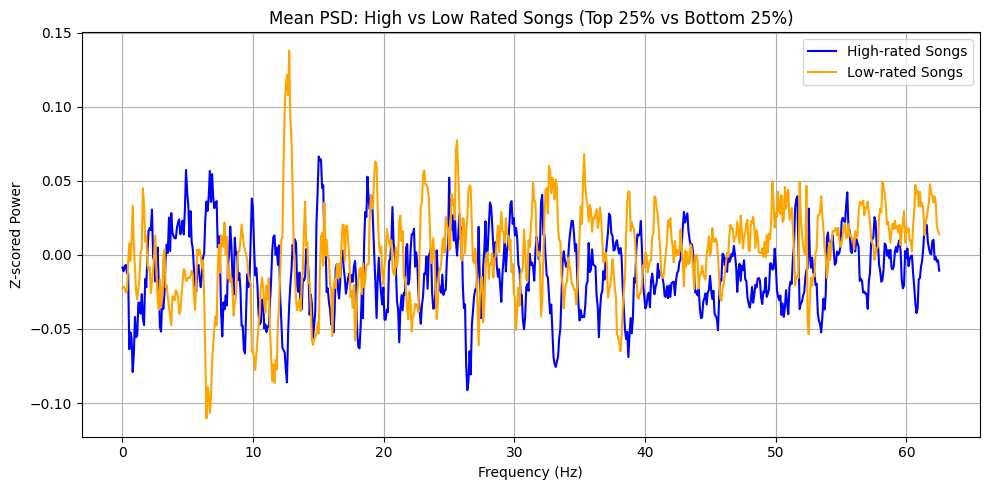

In [114]:
# freqs
freqsall = np.linspace(0, 62.5, 721)

plt.figure(figsize=(10, 5))
plt.plot(freqsall, group_high, label="High-rated Songs", color="blue")
plt.plot(freqsall, group_low, label="Low-rated Songs", color="orange")

plt.title("Mean PSD: High vs Low Rated Songs (Top 25% vs Bottom 25%)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored Power")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Bootstrap**

In [116]:
#boostrap:
abs_diff = []
for i in range(0,29):
    diff= sum(abs(all_high_psd[i] - all_low_psd[i]))
    abs_diff.append(diff)

In [117]:
meandiff = np.mean(abs_diff)
print(meandiff)

238.87243861322165


In [118]:
high_array = np.vstack(all_high_psd)
low_array = np.vstack(all_low_psd)
data = np.vstack([high_array,low_array])

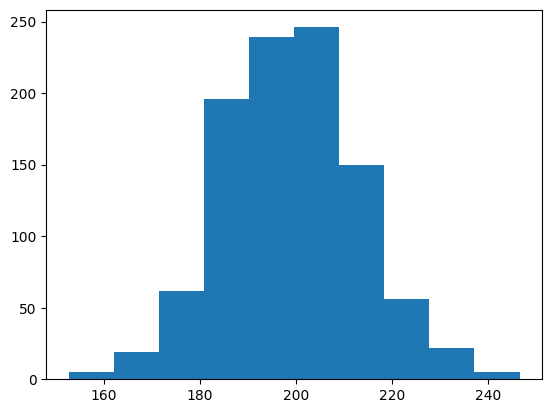

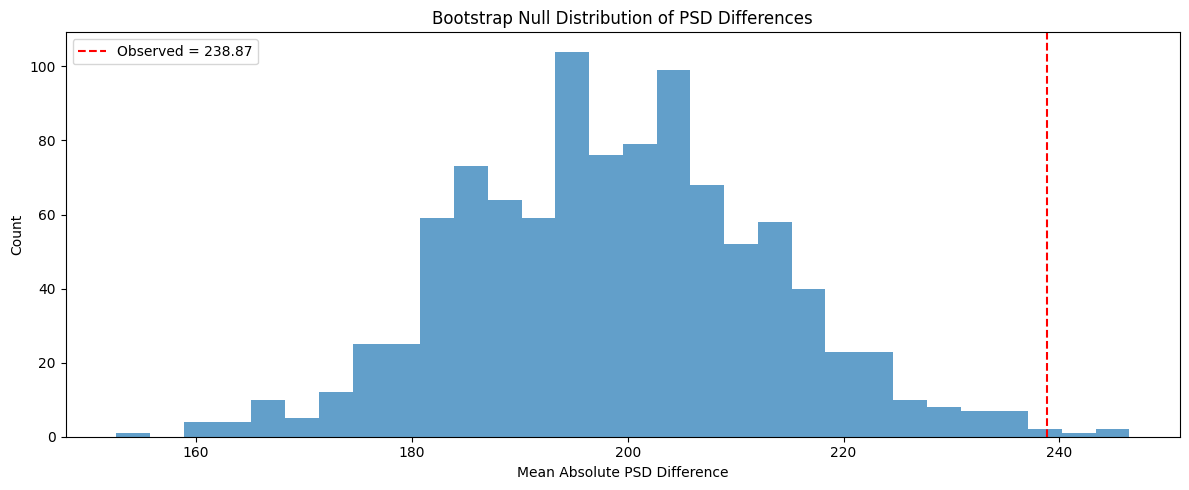

In [119]:

##
n_bootstraps = 1000
bootstrap_stats = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    high = data[np.random.choice(data.shape[0], size=30, replace=True),:]
    low = data[np.random.choice(data.shape[0], size=30, replace=True),:]
    
    diff = np.sum(abs(high - low), axis=1)
    

    bootstrap_stats[i] = np.mean(diff)
    
    
plt.hist(bootstrap_stats)
plt.figure(figsize=(12, 5))
plt.hist(bootstrap_stats, bins=30, alpha=0.7)
plt.axvline(meandiff, color='red', linestyle='--', label=f"Observed = {meandiff:.2f}")
plt.xlabel("Mean Absolute PSD Difference")
plt.ylabel("Count")
plt.title("Bootstrap Null Distribution of PSD Differences")
plt.legend()
plt.tight_layout()
plt.show()


In [120]:
from scipy.io import loadmat       # Import function to read data.
from pylab import *
                # Import numerical and plotting functions
from IPython.lib.display import YouTubeVideo  # Enable YouTube videos
rcParams['figure.figsize']=(12,3)  # Change the default figure size
import numpy as np
from scipy import stats

sample_mean = np.mean(bootstrap_stats)
sample_std = np.std(bootstrap_stats)
sample_size = len(bootstrap_stats)
df = sample_size -1

t_stat = (meandiff - sample_mean)/(sample_std/np.sqrt(sample_size))
p_value = 2*(1-stats.t.cdf(np.abs(t_stat),df))
print(p_value)

0.0


In [122]:
#calculating p value 
p_bootstrap = np.mean(np.abs(bootstrap_stats - sample_mean) >= np.abs(meandiff - sample_mean))
p_bootstrap

np.float64(0.004)